In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "resnet_ce_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM_species"
ood = "1:4"


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 333290 images
Dataset type val label type: species


Loaded 43293 images
Dataset type test label type: species


Loaded 43520 images
Dataset type test label type: species


Loaded 5270 images


In [6]:
# model ids
import pandas as pd
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

1:4 77xb9byl


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-77xb9byl:best, 58.49MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:1.4


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from tqdm import tqdm

trn_inp = []
trn_rcn = []
trn_emb = []
trn_lgt = []
trn_tgt = []

val_inp = []
val_rcn = []
val_emb = []
val_lgt = []
val_tgt = []

ind_inp = []
ind_rcn = []
ind_emb = []
ind_lgt = []
ind_tgt = []

if ood_str:
    ood_inp = []
    ood_rcn = []
    ood_emb = []
    ood_lgt = []
    ood_tgt = []

rnd_inp = []
rnd_rcn = []
rnd_emb = []
rnd_lgt = []

# train set (ind)
for batch_idx, batch in enumerate(tqdm(train_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    emb, lgt, rcn = model(x)
    trn_inp.extend(x.detach().cpu().numpy())
    trn_rcn.extend(rcn.detach().cpu().numpy())
    trn_emb.extend(emb.detach().cpu().numpy())
    trn_lgt.extend(lgt.detach().cpu().numpy())
    trn_tgt.extend(y.detach().cpu().numpy())
print("train - OK")

# val set (ind)
for batch_idx, batch in enumerate(tqdm(val_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    emb, lgt, rcn = model(x)
    val_inp.extend(x.detach().cpu().numpy())
    val_rcn.extend(rcn.detach().cpu().numpy())
    val_emb.extend(emb.detach().cpu().numpy())
    val_lgt.extend(lgt.detach().cpu().numpy())
    val_tgt.extend(y.detach().cpu().numpy())
print("val - OK")

# test set (ind)
for batch_idx, batch in enumerate(tqdm(test_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    emb, lgt, rcn = model(x)
    ind_inp.extend(x.detach().cpu().numpy())
    ind_rcn.extend(rcn.detach().cpu().numpy())
    ind_emb.extend(emb.detach().cpu().numpy())
    ind_lgt.extend(lgt.detach().cpu().numpy())
    ind_tgt.extend(y.detach().cpu().numpy())
print("test InD - OK")

# predict set (ood)
if ood_str:
    for batch_idx, batch in enumerate(tqdm(predict_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        ood_inp.extend(x.detach().cpu().numpy())
        ood_rcn.extend(rcn.detach().cpu().numpy())
        ood_emb.extend(emb.detach().cpu().numpy())
        ood_lgt.extend(lgt.detach().cpu().numpy())
        ood_tgt.extend(y.detach().cpu().numpy())
    print("test OoD - OK")

# random set
rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
for batch_idx, batch in enumerate(tqdm(rnd_set)):
    x = batch
    x = x.float().cuda()
    emb, lgt, rcn = model(x)
    rnd_inp.extend(x.detach().cpu().numpy())
    rnd_rcn.extend(rcn.detach().cpu().numpy())
    rnd_emb.extend(emb.detach().cpu().numpy())
    rnd_lgt.extend(lgt.detach().cpu().numpy())
print("test RnD - OK")

  0%|                                                                                                                                                            | 0/5208 [00:00<?, ?it/s]

  0%|                                                                                                                                                    | 1/5208 [00:00<46:23,  1.87it/s]

  0%|▎                                                                                                                                                   | 9/5208 [00:00<04:46, 18.12it/s]

  0%|▍                                                                                                                                                  | 17/5208 [00:00<02:42, 31.92it/s]

  0%|▋                                                                                                                                                  | 25/5208 [00:00<02:00, 43.04it/s]

  1%|▉                                                                                                                                                  | 33/5208 [00:00<01:40, 51.72it/s]

  1%|█▏                                                                                                                                                 | 41/5208 [00:01<01:28, 58.27it/s]

  1%|█▍                                                                                                                                                 | 49/5208 [00:01<01:21, 63.16it/s]

  1%|█▌                                                                                                                                                 | 57/5208 [00:01<01:17, 66.71it/s]

  1%|█▊                                                                                                                                                 | 65/5208 [00:01<01:14, 69.06it/s]

  1%|██                                                                                                                                                 | 73/5208 [00:01<01:12, 70.93it/s]

  2%|██▎                                                                                                                                                | 81/5208 [00:01<01:10, 72.26it/s]

  2%|██▌                                                                                                                                                | 89/5208 [00:01<01:09, 73.20it/s]

  2%|██▋                                                                                                                                                | 97/5208 [00:01<01:09, 73.74it/s]

  2%|██▉                                                                                                                                               | 105/5208 [00:01<01:08, 74.00it/s]

  2%|███▏                                                                                                                                              | 113/5208 [00:02<01:08, 74.12it/s]

  2%|███▍                                                                                                                                              | 121/5208 [00:02<01:08, 74.25it/s]

  2%|███▌                                                                                                                                              | 129/5208 [00:02<01:08, 74.32it/s]

  3%|███▊                                                                                                                                              | 137/5208 [00:02<01:08, 74.39it/s]

  3%|████                                                                                                                                              | 145/5208 [00:02<01:08, 74.43it/s]

  3%|████▎                                                                                                                                             | 153/5208 [00:02<01:07, 74.48it/s]

  3%|████▌                                                                                                                                             | 161/5208 [00:02<01:07, 74.49it/s]

  3%|████▋                                                                                                                                             | 169/5208 [00:02<01:07, 74.54it/s]

  3%|████▉                                                                                                                                             | 177/5208 [00:02<01:07, 74.53it/s]

  4%|█████▏                                                                                                                                            | 185/5208 [00:02<01:07, 74.55it/s]

  4%|█████▍                                                                                                                                            | 193/5208 [00:03<01:07, 74.52it/s]

  4%|█████▋                                                                                                                                            | 201/5208 [00:03<01:07, 74.51it/s]

  4%|█████▊                                                                                                                                            | 209/5208 [00:03<01:06, 74.69it/s]

  4%|██████                                                                                                                                            | 217/5208 [00:03<01:06, 74.85it/s]

  4%|██████▎                                                                                                                                           | 225/5208 [00:03<01:06, 74.97it/s]

  4%|██████▌                                                                                                                                           | 233/5208 [00:03<01:06, 75.18it/s]

  5%|██████▊                                                                                                                                           | 241/5208 [00:03<01:05, 75.29it/s]

  5%|██████▉                                                                                                                                           | 249/5208 [00:03<01:05, 75.42it/s]

  5%|███████▏                                                                                                                                          | 257/5208 [00:03<01:05, 75.44it/s]

  5%|███████▍                                                                                                                                          | 265/5208 [00:04<01:05, 75.46it/s]

  5%|███████▋                                                                                                                                          | 273/5208 [00:04<01:05, 75.67it/s]

  5%|███████▉                                                                                                                                          | 281/5208 [00:04<01:05, 75.59it/s]

  6%|████████                                                                                                                                          | 289/5208 [00:04<01:05, 75.55it/s]

  6%|████████▎                                                                                                                                         | 297/5208 [00:04<01:04, 75.62it/s]

  6%|████████▌                                                                                                                                         | 305/5208 [00:04<01:04, 75.60it/s]

  6%|████████▊                                                                                                                                         | 313/5208 [00:04<01:04, 75.54it/s]

  6%|████████▉                                                                                                                                         | 321/5208 [00:04<01:04, 75.62it/s]

  6%|█████████▏                                                                                                                                        | 329/5208 [00:04<01:04, 75.58it/s]

  6%|█████████▍                                                                                                                                        | 337/5208 [00:05<01:04, 75.54it/s]

  7%|█████████▋                                                                                                                                        | 345/5208 [00:05<01:04, 75.53it/s]

  7%|█████████▉                                                                                                                                        | 353/5208 [00:05<01:04, 75.52it/s]

  7%|██████████                                                                                                                                        | 361/5208 [00:05<01:04, 75.35it/s]

  7%|██████████▎                                                                                                                                       | 369/5208 [00:05<01:04, 75.25it/s]

  7%|██████████▌                                                                                                                                       | 377/5208 [00:05<01:04, 75.22it/s]

  7%|██████████▊                                                                                                                                       | 385/5208 [00:05<01:04, 74.96it/s]

  8%|███████████                                                                                                                                       | 393/5208 [00:05<01:04, 75.06it/s]

  8%|███████████▏                                                                                                                                      | 401/5208 [00:05<01:03, 75.15it/s]

  8%|███████████▍                                                                                                                                      | 409/5208 [00:05<01:03, 75.22it/s]

  8%|███████████▋                                                                                                                                      | 417/5208 [00:06<01:03, 75.27it/s]

  8%|███████████▉                                                                                                                                      | 425/5208 [00:06<01:03, 75.35it/s]

  8%|████████████▏                                                                                                                                     | 433/5208 [00:06<01:03, 75.37it/s]

  8%|████████████▎                                                                                                                                     | 441/5208 [00:06<01:03, 75.39it/s]

  9%|████████████▌                                                                                                                                     | 449/5208 [00:06<01:03, 75.44it/s]

  9%|████████████▊                                                                                                                                     | 457/5208 [00:06<01:03, 75.36it/s]

  9%|█████████████                                                                                                                                     | 465/5208 [00:06<01:02, 75.38it/s]

  9%|█████████████▎                                                                                                                                    | 473/5208 [00:06<01:02, 75.41it/s]

  9%|█████████████▍                                                                                                                                    | 481/5208 [00:06<01:02, 75.40it/s]

  9%|█████████████▋                                                                                                                                    | 489/5208 [00:07<01:02, 75.44it/s]

 10%|█████████████▉                                                                                                                                    | 497/5208 [00:07<01:02, 75.38it/s]

 10%|██████████████▏                                                                                                                                   | 505/5208 [00:07<01:02, 75.37it/s]

 10%|██████████████▍                                                                                                                                   | 513/5208 [00:07<01:02, 75.36it/s]

 10%|██████████████▌                                                                                                                                   | 521/5208 [00:07<01:02, 75.36it/s]

 10%|██████████████▊                                                                                                                                   | 529/5208 [00:07<01:02, 75.19it/s]

 10%|███████████████                                                                                                                                   | 537/5208 [00:07<01:02, 75.24it/s]

 10%|███████████████▎                                                                                                                                  | 545/5208 [00:07<01:01, 75.27it/s]

 11%|███████████████▌                                                                                                                                  | 553/5208 [00:07<01:01, 75.31it/s]

 11%|███████████████▋                                                                                                                                  | 561/5208 [00:07<01:01, 75.29it/s]

 11%|███████████████▉                                                                                                                                  | 569/5208 [00:08<01:01, 75.30it/s]

 11%|████████████████▏                                                                                                                                 | 577/5208 [00:08<01:01, 75.24it/s]

 11%|████████████████▍                                                                                                                                 | 585/5208 [00:08<01:01, 75.33it/s]

 11%|████████████████▌                                                                                                                                 | 593/5208 [00:08<01:01, 75.35it/s]

 12%|████████████████▊                                                                                                                                 | 601/5208 [00:08<01:01, 75.36it/s]

 12%|█████████████████                                                                                                                                 | 609/5208 [00:08<01:01, 75.37it/s]

 12%|█████████████████▎                                                                                                                                | 617/5208 [00:08<01:00, 75.38it/s]

 12%|█████████████████▌                                                                                                                                | 625/5208 [00:08<01:00, 75.39it/s]

 12%|█████████████████▋                                                                                                                                | 633/5208 [00:08<01:00, 75.39it/s]

 12%|█████████████████▉                                                                                                                                | 641/5208 [00:09<01:00, 75.38it/s]

 12%|██████████████████▏                                                                                                                               | 649/5208 [00:09<01:00, 75.30it/s]

 13%|██████████████████▍                                                                                                                               | 657/5208 [00:09<01:00, 75.34it/s]

 13%|██████████████████▋                                                                                                                               | 665/5208 [00:09<01:00, 75.45it/s]

 13%|██████████████████▊                                                                                                                               | 673/5208 [00:09<01:00, 75.43it/s]

 13%|███████████████████                                                                                                                               | 681/5208 [00:09<01:00, 75.41it/s]

 13%|███████████████████▎                                                                                                                              | 689/5208 [00:09<00:59, 75.40it/s]

 13%|███████████████████▌                                                                                                                              | 697/5208 [00:09<00:59, 75.42it/s]

 14%|███████████████████▊                                                                                                                              | 705/5208 [00:09<00:59, 75.40it/s]

 14%|███████████████████▉                                                                                                                              | 713/5208 [00:09<00:59, 75.43it/s]

 14%|████████████████████▏                                                                                                                             | 721/5208 [00:10<00:59, 75.60it/s]

 14%|████████████████████▍                                                                                                                             | 729/5208 [00:10<00:59, 75.50it/s]

 14%|████████████████████▋                                                                                                                             | 737/5208 [00:10<00:59, 75.49it/s]

 14%|████████████████████▉                                                                                                                             | 745/5208 [00:10<00:59, 75.26it/s]

 14%|█████████████████████                                                                                                                             | 753/5208 [00:10<00:59, 75.09it/s]

 15%|█████████████████████▎                                                                                                                            | 761/5208 [00:10<00:59, 75.07it/s]

 15%|█████████████████████▌                                                                                                                            | 769/5208 [00:10<00:59, 75.06it/s]

 15%|█████████████████████▊                                                                                                                            | 777/5208 [00:10<00:59, 75.02it/s]

 15%|██████████████████████                                                                                                                            | 785/5208 [00:10<00:58, 75.13it/s]

 15%|██████████████████████▏                                                                                                                           | 793/5208 [00:11<00:58, 74.98it/s]

 15%|██████████████████████▍                                                                                                                           | 801/5208 [00:11<00:58, 74.92it/s]

 16%|██████████████████████▋                                                                                                                           | 809/5208 [00:11<00:58, 75.02it/s]

 16%|██████████████████████▉                                                                                                                           | 817/5208 [00:11<00:58, 75.14it/s]

 16%|███████████████████████▏                                                                                                                          | 825/5208 [00:11<00:58, 75.19it/s]

 16%|███████████████████████▎                                                                                                                          | 833/5208 [00:11<00:58, 75.15it/s]

 16%|███████████████████████▌                                                                                                                          | 841/5208 [00:11<00:58, 75.20it/s]

 16%|███████████████████████▊                                                                                                                          | 849/5208 [00:11<00:57, 75.19it/s]

 16%|████████████████████████                                                                                                                          | 857/5208 [00:11<00:57, 75.03it/s]

 17%|████████████████████████▏                                                                                                                         | 865/5208 [00:12<00:57, 75.06it/s]

 17%|████████████████████████▍                                                                                                                         | 873/5208 [00:12<00:57, 74.82it/s]

 17%|████████████████████████▋                                                                                                                         | 881/5208 [00:12<00:57, 75.02it/s]

 17%|████████████████████████▉                                                                                                                         | 889/5208 [00:12<00:57, 75.06it/s]

 17%|█████████████████████████▏                                                                                                                        | 897/5208 [00:12<00:57, 75.18it/s]

 17%|█████████████████████████▎                                                                                                                        | 905/5208 [00:12<00:57, 75.26it/s]

 18%|█████████████████████████▌                                                                                                                        | 913/5208 [00:12<00:57, 75.35it/s]

 18%|█████████████████████████▊                                                                                                                        | 921/5208 [00:12<00:56, 75.32it/s]

 18%|██████████████████████████                                                                                                                        | 929/5208 [00:12<00:56, 75.14it/s]

 18%|██████████████████████████▎                                                                                                                       | 937/5208 [00:12<00:57, 74.90it/s]

 18%|██████████████████████████▍                                                                                                                       | 945/5208 [00:13<00:57, 74.78it/s]

 18%|██████████████████████████▋                                                                                                                       | 953/5208 [00:13<00:56, 74.70it/s]

 18%|██████████████████████████▉                                                                                                                       | 961/5208 [00:13<00:56, 74.69it/s]

 19%|███████████████████████████▏                                                                                                                      | 969/5208 [00:13<00:56, 74.59it/s]

 19%|███████████████████████████▍                                                                                                                      | 977/5208 [00:13<00:56, 74.59it/s]

 19%|███████████████████████████▌                                                                                                                      | 985/5208 [00:13<00:56, 74.58it/s]

 19%|███████████████████████████▊                                                                                                                      | 993/5208 [00:13<00:56, 74.59it/s]

 19%|███████████████████████████▊                                                                                                                     | 1001/5208 [00:13<00:56, 74.53it/s]

 19%|████████████████████████████                                                                                                                     | 1009/5208 [00:13<00:56, 74.54it/s]

 20%|████████████████████████████▎                                                                                                                    | 1017/5208 [00:14<00:56, 74.61it/s]

 20%|████████████████████████████▌                                                                                                                    | 1025/5208 [00:14<00:56, 74.62it/s]

 20%|████████████████████████████▊                                                                                                                    | 1033/5208 [00:14<00:55, 74.63it/s]

 20%|████████████████████████████▉                                                                                                                    | 1041/5208 [00:14<00:55, 74.47it/s]

 20%|█████████████████████████████▏                                                                                                                   | 1049/5208 [00:14<00:55, 74.75it/s]

 20%|█████████████████████████████▍                                                                                                                   | 1057/5208 [00:14<00:55, 74.79it/s]

 20%|█████████████████████████████▋                                                                                                                   | 1065/5208 [00:14<00:55, 74.72it/s]

 21%|█████████████████████████████▊                                                                                                                   | 1073/5208 [00:14<00:55, 74.68it/s]

 21%|██████████████████████████████                                                                                                                   | 1081/5208 [00:14<00:55, 74.92it/s]

 21%|██████████████████████████████▎                                                                                                                  | 1089/5208 [00:15<00:54, 75.07it/s]

 21%|██████████████████████████████▌                                                                                                                  | 1097/5208 [00:15<00:54, 75.09it/s]

 21%|██████████████████████████████▊                                                                                                                  | 1105/5208 [00:15<00:54, 75.02it/s]

 21%|██████████████████████████████▉                                                                                                                  | 1113/5208 [00:15<00:54, 75.12it/s]

 22%|███████████████████████████████▏                                                                                                                 | 1121/5208 [00:15<00:54, 75.12it/s]

 22%|███████████████████████████████▍                                                                                                                 | 1129/5208 [00:15<00:54, 74.97it/s]

 22%|███████████████████████████████▋                                                                                                                 | 1137/5208 [00:15<00:54, 74.96it/s]

 22%|███████████████████████████████▉                                                                                                                 | 1145/5208 [00:15<00:53, 75.26it/s]

 22%|████████████████████████████████                                                                                                                 | 1153/5208 [00:15<00:53, 75.41it/s]

 22%|████████████████████████████████▎                                                                                                                | 1161/5208 [00:15<00:53, 75.31it/s]

 22%|████████████████████████████████▌                                                                                                                | 1169/5208 [00:16<00:53, 75.15it/s]

 23%|████████████████████████████████▊                                                                                                                | 1177/5208 [00:16<00:53, 75.15it/s]

 23%|████████████████████████████████▉                                                                                                                | 1185/5208 [00:16<00:53, 75.00it/s]

 23%|█████████████████████████████████▏                                                                                                               | 1193/5208 [00:16<00:53, 74.87it/s]

 23%|█████████████████████████████████▍                                                                                                               | 1201/5208 [00:16<00:53, 74.81it/s]

 23%|█████████████████████████████████▋                                                                                                               | 1209/5208 [00:16<00:53, 74.74it/s]

 23%|█████████████████████████████████▉                                                                                                               | 1217/5208 [00:16<00:53, 74.67it/s]

 24%|██████████████████████████████████                                                                                                               | 1225/5208 [00:16<00:53, 74.64it/s]

 24%|██████████████████████████████████▎                                                                                                              | 1233/5208 [00:16<00:53, 74.61it/s]

 24%|██████████████████████████████████▌                                                                                                              | 1241/5208 [00:17<00:53, 74.59it/s]

 24%|██████████████████████████████████▊                                                                                                              | 1249/5208 [00:17<00:53, 74.57it/s]

 24%|██████████████████████████████████▉                                                                                                              | 1257/5208 [00:17<00:52, 74.65it/s]

 24%|███████████████████████████████████▏                                                                                                             | 1265/5208 [00:17<00:52, 74.65it/s]

 24%|███████████████████████████████████▍                                                                                                             | 1273/5208 [00:17<00:52, 74.69it/s]

 25%|███████████████████████████████████▋                                                                                                             | 1281/5208 [00:17<00:52, 74.65it/s]

 25%|███████████████████████████████████▉                                                                                                             | 1289/5208 [00:17<00:52, 74.61it/s]

 25%|████████████████████████████████████                                                                                                             | 1297/5208 [00:17<00:52, 74.65it/s]

 25%|████████████████████████████████████▎                                                                                                            | 1305/5208 [00:17<00:52, 74.79it/s]

 25%|████████████████████████████████████▌                                                                                                            | 1313/5208 [00:18<00:51, 74.93it/s]

 25%|████████████████████████████████████▊                                                                                                            | 1321/5208 [00:18<00:51, 75.04it/s]

 26%|█████████████████████████████████████                                                                                                            | 1329/5208 [00:18<00:51, 75.10it/s]

 26%|█████████████████████████████████████▏                                                                                                           | 1337/5208 [00:18<00:51, 75.11it/s]

 26%|█████████████████████████████████████▍                                                                                                           | 1345/5208 [00:18<00:51, 75.14it/s]

 26%|█████████████████████████████████████▋                                                                                                           | 1353/5208 [00:18<00:51, 75.19it/s]

 26%|█████████████████████████████████████▉                                                                                                           | 1361/5208 [00:18<00:51, 75.24it/s]

 26%|██████████████████████████████████████                                                                                                           | 1369/5208 [00:18<00:51, 75.22it/s]

 26%|██████████████████████████████████████▎                                                                                                          | 1377/5208 [00:18<00:51, 75.03it/s]

 27%|██████████████████████████████████████▌                                                                                                          | 1385/5208 [00:18<00:51, 74.88it/s]

 27%|██████████████████████████████████████▊                                                                                                          | 1393/5208 [00:19<00:50, 74.92it/s]

 27%|███████████████████████████████████████                                                                                                          | 1401/5208 [00:19<00:50, 74.98it/s]

 27%|███████████████████████████████████████▏                                                                                                         | 1409/5208 [00:19<00:50, 74.98it/s]

 27%|███████████████████████████████████████▍                                                                                                         | 1417/5208 [00:19<00:50, 74.85it/s]

 27%|███████████████████████████████████████▋                                                                                                         | 1425/5208 [00:19<00:50, 74.79it/s]

 28%|███████████████████████████████████████▉                                                                                                         | 1433/5208 [00:19<00:50, 74.72it/s]

 28%|████████████████████████████████████████                                                                                                         | 1441/5208 [00:19<00:50, 74.82it/s]

 28%|████████████████████████████████████████▎                                                                                                        | 1449/5208 [00:19<00:50, 74.64it/s]

 28%|████████████████████████████████████████▌                                                                                                        | 1457/5208 [00:19<00:50, 74.72it/s]

 28%|████████████████████████████████████████▊                                                                                                        | 1465/5208 [00:20<00:49, 74.98it/s]

 28%|█████████████████████████████████████████                                                                                                        | 1473/5208 [00:20<00:49, 75.09it/s]

 28%|█████████████████████████████████████████▏                                                                                                       | 1481/5208 [00:20<00:49, 75.01it/s]

 29%|█████████████████████████████████████████▍                                                                                                       | 1489/5208 [00:20<00:49, 75.12it/s]

 29%|█████████████████████████████████████████▋                                                                                                       | 1497/5208 [00:20<00:49, 75.15it/s]

 29%|█████████████████████████████████████████▉                                                                                                       | 1505/5208 [00:20<00:49, 75.18it/s]

 29%|██████████████████████████████████████████                                                                                                       | 1513/5208 [00:20<00:49, 75.21it/s]

 29%|██████████████████████████████████████████▎                                                                                                      | 1521/5208 [00:20<00:48, 75.26it/s]

 29%|██████████████████████████████████████████▌                                                                                                      | 1529/5208 [00:20<00:48, 75.27it/s]

 30%|██████████████████████████████████████████▊                                                                                                      | 1537/5208 [00:20<00:48, 75.31it/s]

 30%|███████████████████████████████████████████                                                                                                      | 1545/5208 [00:21<00:48, 75.33it/s]

 30%|███████████████████████████████████████████▏                                                                                                     | 1553/5208 [00:21<00:48, 75.27it/s]

 30%|███████████████████████████████████████████▍                                                                                                     | 1561/5208 [00:21<00:48, 75.26it/s]

 30%|███████████████████████████████████████████▋                                                                                                     | 1569/5208 [00:21<00:48, 75.25it/s]

 30%|███████████████████████████████████████████▉                                                                                                     | 1577/5208 [00:21<00:48, 75.26it/s]

 30%|████████████████████████████████████████████▏                                                                                                    | 1585/5208 [00:21<00:48, 75.18it/s]

 31%|████████████████████████████████████████████▎                                                                                                    | 1593/5208 [00:21<00:48, 75.25it/s]

 31%|████████████████████████████████████████████▌                                                                                                    | 1601/5208 [00:21<00:48, 75.11it/s]

 31%|████████████████████████████████████████████▊                                                                                                    | 1609/5208 [00:21<00:47, 75.09it/s]

 31%|█████████████████████████████████████████████                                                                                                    | 1617/5208 [00:22<00:47, 75.08it/s]

 31%|█████████████████████████████████████████████▏                                                                                                   | 1625/5208 [00:22<00:47, 75.08it/s]

 31%|█████████████████████████████████████████████▍                                                                                                   | 1633/5208 [00:22<00:47, 75.17it/s]

 32%|█████████████████████████████████████████████▋                                                                                                   | 1641/5208 [00:22<00:47, 75.20it/s]

 32%|█████████████████████████████████████████████▉                                                                                                   | 1649/5208 [00:22<00:47, 75.19it/s]

 32%|██████████████████████████████████████████████▏                                                                                                  | 1657/5208 [00:22<00:47, 75.17it/s]

 32%|██████████████████████████████████████████████▎                                                                                                  | 1665/5208 [00:22<00:47, 75.04it/s]

 32%|██████████████████████████████████████████████▌                                                                                                  | 1673/5208 [00:22<00:47, 75.07it/s]

 32%|██████████████████████████████████████████████▊                                                                                                  | 1681/5208 [00:22<00:46, 75.07it/s]

 32%|███████████████████████████████████████████████                                                                                                  | 1689/5208 [00:23<00:46, 75.10it/s]

 33%|███████████████████████████████████████████████▏                                                                                                 | 1697/5208 [00:23<00:46, 75.17it/s]

 33%|███████████████████████████████████████████████▍                                                                                                 | 1705/5208 [00:23<00:46, 75.23it/s]

 33%|███████████████████████████████████████████████▋                                                                                                 | 1713/5208 [00:23<00:46, 75.32it/s]

 33%|███████████████████████████████████████████████▉                                                                                                 | 1721/5208 [00:23<00:46, 75.36it/s]

 33%|████████████████████████████████████████████████▏                                                                                                | 1729/5208 [00:23<00:46, 75.37it/s]

 33%|████████████████████████████████████████████████▎                                                                                                | 1737/5208 [00:23<00:46, 75.42it/s]

 34%|████████████████████████████████████████████████▌                                                                                                | 1745/5208 [00:23<00:45, 75.40it/s]

 34%|████████████████████████████████████████████████▊                                                                                                | 1753/5208 [00:23<00:45, 75.43it/s]

 34%|█████████████████████████████████████████████████                                                                                                | 1761/5208 [00:23<00:45, 75.41it/s]

 34%|█████████████████████████████████████████████████▎                                                                                               | 1769/5208 [00:24<00:45, 75.61it/s]

 34%|█████████████████████████████████████████████████▍                                                                                               | 1777/5208 [00:24<00:45, 75.57it/s]

 34%|█████████████████████████████████████████████████▋                                                                                               | 1785/5208 [00:24<00:45, 75.56it/s]

 34%|█████████████████████████████████████████████████▉                                                                                               | 1793/5208 [00:24<00:45, 75.51it/s]

 35%|██████████████████████████████████████████████████▏                                                                                              | 1801/5208 [00:24<00:45, 75.50it/s]

 35%|██████████████████████████████████████████████████▎                                                                                              | 1809/5208 [00:24<00:44, 75.58it/s]

 35%|██████████████████████████████████████████████████▌                                                                                              | 1817/5208 [00:24<00:44, 75.56it/s]

 35%|██████████████████████████████████████████████████▊                                                                                              | 1825/5208 [00:24<00:44, 75.53it/s]

 35%|███████████████████████████████████████████████████                                                                                              | 1833/5208 [00:24<00:44, 75.52it/s]

 35%|███████████████████████████████████████████████████▎                                                                                             | 1841/5208 [00:25<00:44, 75.59it/s]

 36%|███████████████████████████████████████████████████▍                                                                                             | 1849/5208 [00:25<00:44, 75.65it/s]

 36%|███████████████████████████████████████████████████▋                                                                                             | 1857/5208 [00:25<00:44, 75.59it/s]

 36%|███████████████████████████████████████████████████▉                                                                                             | 1865/5208 [00:25<00:44, 75.55it/s]

 36%|████████████████████████████████████████████████████▏                                                                                            | 1873/5208 [00:25<00:44, 75.03it/s]

 36%|████████████████████████████████████████████████████▎                                                                                            | 1881/5208 [00:25<00:43, 75.93it/s]

 36%|████████████████████████████████████████████████████▌                                                                                            | 1889/5208 [00:25<00:43, 76.57it/s]

 36%|████████████████████████████████████████████████████▊                                                                                            | 1897/5208 [00:25<00:42, 77.03it/s]

 37%|█████████████████████████████████████████████████████                                                                                            | 1905/5208 [00:25<00:42, 77.36it/s]

 37%|█████████████████████████████████████████████████████▎                                                                                           | 1913/5208 [00:25<00:42, 77.49it/s]

 37%|█████████████████████████████████████████████████████▍                                                                                           | 1921/5208 [00:26<00:42, 77.43it/s]

 37%|█████████████████████████████████████████████████████▋                                                                                           | 1929/5208 [00:26<00:42, 77.25it/s]

 37%|█████████████████████████████████████████████████████▉                                                                                           | 1937/5208 [00:26<00:42, 77.31it/s]

 37%|██████████████████████████████████████████████████████▏                                                                                          | 1945/5208 [00:26<00:42, 77.43it/s]

 38%|██████████████████████████████████████████████████████▍                                                                                          | 1953/5208 [00:26<00:41, 77.53it/s]

 38%|██████████████████████████████████████████████████████▌                                                                                          | 1961/5208 [00:26<00:41, 77.54it/s]

 38%|██████████████████████████████████████████████████████▊                                                                                          | 1969/5208 [00:26<00:41, 77.62it/s]

 38%|███████████████████████████████████████████████████████                                                                                          | 1977/5208 [00:26<00:41, 77.65it/s]

 38%|███████████████████████████████████████████████████████▎                                                                                         | 1985/5208 [00:26<00:41, 77.56it/s]

 38%|███████████████████████████████████████████████████████▍                                                                                         | 1993/5208 [00:26<00:41, 77.59it/s]

 38%|███████████████████████████████████████████████████████▋                                                                                         | 2001/5208 [00:27<00:41, 77.62it/s]

 39%|███████████████████████████████████████████████████████▉                                                                                         | 2009/5208 [00:27<00:41, 77.19it/s]

 39%|████████████████████████████████████████████████████████▏                                                                                        | 2017/5208 [00:27<00:41, 77.28it/s]

 39%|████████████████████████████████████████████████████████▍                                                                                        | 2025/5208 [00:27<00:41, 77.41it/s]

 39%|████████████████████████████████████████████████████████▌                                                                                        | 2033/5208 [00:27<00:40, 77.52it/s]

 39%|████████████████████████████████████████████████████████▊                                                                                        | 2041/5208 [00:27<00:40, 77.47it/s]

 39%|█████████████████████████████████████████████████████████                                                                                        | 2049/5208 [00:27<00:40, 77.51it/s]

 39%|█████████████████████████████████████████████████████████▎                                                                                       | 2057/5208 [00:27<00:40, 77.55it/s]

 40%|█████████████████████████████████████████████████████████▍                                                                                       | 2065/5208 [00:27<00:40, 77.51it/s]

 40%|█████████████████████████████████████████████████████████▋                                                                                       | 2073/5208 [00:28<00:40, 77.60it/s]

 40%|█████████████████████████████████████████████████████████▉                                                                                       | 2081/5208 [00:28<00:40, 77.60it/s]

 40%|██████████████████████████████████████████████████████████▏                                                                                      | 2089/5208 [00:28<00:40, 77.64it/s]

 40%|██████████████████████████████████████████████████████████▍                                                                                      | 2097/5208 [00:28<00:40, 77.51it/s]

 40%|██████████████████████████████████████████████████████████▌                                                                                      | 2105/5208 [00:28<00:40, 77.27it/s]

 41%|██████████████████████████████████████████████████████████▊                                                                                      | 2113/5208 [00:28<00:40, 76.70it/s]

 41%|███████████████████████████████████████████████████████████                                                                                      | 2121/5208 [00:28<00:40, 76.19it/s]

 41%|███████████████████████████████████████████████████████████▎                                                                                     | 2129/5208 [00:28<00:40, 75.77it/s]

 41%|███████████████████████████████████████████████████████████▍                                                                                     | 2137/5208 [00:28<00:40, 75.56it/s]

 41%|███████████████████████████████████████████████████████████▋                                                                                     | 2145/5208 [00:28<00:40, 75.46it/s]

 41%|███████████████████████████████████████████████████████████▉                                                                                     | 2153/5208 [00:29<00:40, 75.45it/s]

 41%|████████████████████████████████████████████████████████████▏                                                                                    | 2161/5208 [00:29<00:40, 75.41it/s]

 42%|████████████████████████████████████████████████████████████▍                                                                                    | 2169/5208 [00:29<00:40, 75.36it/s]

 42%|████████████████████████████████████████████████████████████▌                                                                                    | 2177/5208 [00:29<00:40, 75.48it/s]

 42%|████████████████████████████████████████████████████████████▊                                                                                    | 2185/5208 [00:29<00:40, 75.43it/s]

 42%|█████████████████████████████████████████████████████████████                                                                                    | 2193/5208 [00:29<00:39, 75.44it/s]

 42%|█████████████████████████████████████████████████████████████▎                                                                                   | 2201/5208 [00:29<00:39, 75.45it/s]

 42%|█████████████████████████████████████████████████████████████▌                                                                                   | 2209/5208 [00:29<00:39, 75.45it/s]

 43%|█████████████████████████████████████████████████████████████▋                                                                                   | 2217/5208 [00:29<00:39, 75.25it/s]

 43%|█████████████████████████████████████████████████████████████▉                                                                                   | 2225/5208 [00:30<00:39, 75.15it/s]

 43%|██████████████████████████████████████████████████████████████▏                                                                                  | 2233/5208 [00:30<00:39, 75.00it/s]

 43%|██████████████████████████████████████████████████████████████▍                                                                                  | 2241/5208 [00:30<00:39, 74.89it/s]

 43%|██████████████████████████████████████████████████████████████▌                                                                                  | 2249/5208 [00:30<00:39, 74.77it/s]

 43%|██████████████████████████████████████████████████████████████▊                                                                                  | 2257/5208 [00:30<00:39, 74.73it/s]

 43%|███████████████████████████████████████████████████████████████                                                                                  | 2265/5208 [00:30<00:39, 74.69it/s]

 44%|███████████████████████████████████████████████████████████████▎                                                                                 | 2273/5208 [00:30<00:39, 74.69it/s]

 44%|███████████████████████████████████████████████████████████████▌                                                                                 | 2281/5208 [00:30<00:39, 74.67it/s]

 44%|███████████████████████████████████████████████████████████████▋                                                                                 | 2289/5208 [00:30<00:39, 74.66it/s]

 44%|███████████████████████████████████████████████████████████████▉                                                                                 | 2297/5208 [00:31<00:38, 74.65it/s]

 44%|████████████████████████████████████████████████████████████████▏                                                                                | 2305/5208 [00:31<00:38, 74.65it/s]

 44%|████████████████████████████████████████████████████████████████▍                                                                                | 2313/5208 [00:31<00:38, 74.66it/s]

 45%|████████████████████████████████████████████████████████████████▌                                                                                | 2321/5208 [00:31<00:38, 74.69it/s]

 45%|████████████████████████████████████████████████████████████████▊                                                                                | 2329/5208 [00:31<00:38, 74.70it/s]

 45%|█████████████████████████████████████████████████████████████████                                                                                | 2337/5208 [00:31<00:38, 74.71it/s]

 45%|█████████████████████████████████████████████████████████████████▎                                                                               | 2345/5208 [00:31<00:38, 74.70it/s]

 45%|█████████████████████████████████████████████████████████████████▌                                                                               | 2353/5208 [00:31<00:38, 74.78it/s]

 45%|█████████████████████████████████████████████████████████████████▋                                                                               | 2361/5208 [00:31<00:38, 74.84it/s]

 45%|█████████████████████████████████████████████████████████████████▉                                                                               | 2369/5208 [00:31<00:38, 74.54it/s]

 46%|██████████████████████████████████████████████████████████████████▏                                                                              | 2377/5208 [00:32<00:37, 74.81it/s]

 46%|██████████████████████████████████████████████████████████████████▍                                                                              | 2385/5208 [00:32<00:37, 74.83it/s]

 46%|██████████████████████████████████████████████████████████████████▋                                                                              | 2393/5208 [00:32<00:37, 75.18it/s]

 46%|██████████████████████████████████████████████████████████████████▊                                                                              | 2401/5208 [00:32<00:37, 75.30it/s]

 46%|███████████████████████████████████████████████████████████████████                                                                              | 2409/5208 [00:32<00:37, 75.41it/s]

 46%|███████████████████████████████████████████████████████████████████▎                                                                             | 2417/5208 [00:32<00:36, 75.49it/s]

 47%|███████████████████████████████████████████████████████████████████▌                                                                             | 2425/5208 [00:32<00:36, 75.56it/s]

 47%|███████████████████████████████████████████████████████████████████▋                                                                             | 2433/5208 [00:32<00:36, 75.57it/s]

 47%|███████████████████████████████████████████████████████████████████▉                                                                             | 2441/5208 [00:32<00:36, 75.64it/s]

 47%|████████████████████████████████████████████████████████████████████▏                                                                            | 2449/5208 [00:33<00:36, 75.65it/s]

 47%|████████████████████████████████████████████████████████████████████▍                                                                            | 2457/5208 [00:33<00:36, 75.82it/s]

 47%|████████████████████████████████████████████████████████████████████▋                                                                            | 2465/5208 [00:33<00:36, 75.87it/s]

 47%|████████████████████████████████████████████████████████████████████▊                                                                            | 2473/5208 [00:33<00:36, 75.84it/s]

 48%|█████████████████████████████████████████████████████████████████████                                                                            | 2481/5208 [00:33<00:35, 75.78it/s]

 48%|█████████████████████████████████████████████████████████████████████▎                                                                           | 2489/5208 [00:33<00:35, 75.76it/s]

 48%|█████████████████████████████████████████████████████████████████████▌                                                                           | 2497/5208 [00:33<00:35, 75.73it/s]

 48%|█████████████████████████████████████████████████████████████████████▋                                                                           | 2505/5208 [00:33<00:35, 75.70it/s]

 48%|█████████████████████████████████████████████████████████████████████▉                                                                           | 2513/5208 [00:33<00:35, 75.69it/s]

 48%|██████████████████████████████████████████████████████████████████████▏                                                                          | 2521/5208 [00:33<00:35, 75.49it/s]

 49%|██████████████████████████████████████████████████████████████████████▍                                                                          | 2529/5208 [00:34<00:35, 75.41it/s]

 49%|██████████████████████████████████████████████████████████████████████▋                                                                          | 2537/5208 [00:34<00:35, 75.40it/s]

 49%|██████████████████████████████████████████████████████████████████████▊                                                                          | 2545/5208 [00:34<00:35, 75.52it/s]

 49%|███████████████████████████████████████████████████████████████████████                                                                          | 2553/5208 [00:34<00:35, 75.46it/s]

 49%|███████████████████████████████████████████████████████████████████████▎                                                                         | 2561/5208 [00:34<00:35, 75.47it/s]

 49%|███████████████████████████████████████████████████████████████████████▌                                                                         | 2569/5208 [00:34<00:34, 75.47it/s]

 49%|███████████████████████████████████████████████████████████████████████▋                                                                         | 2577/5208 [00:34<00:34, 75.47it/s]

 50%|███████████████████████████████████████████████████████████████████████▉                                                                         | 2585/5208 [00:34<00:34, 75.42it/s]

 50%|████████████████████████████████████████████████████████████████████████▏                                                                        | 2593/5208 [00:34<00:34, 74.94it/s]

 50%|████████████████████████████████████████████████████████████████████████▍                                                                        | 2601/5208 [00:35<00:34, 74.94it/s]

 50%|████████████████████████████████████████████████████████████████████████▋                                                                        | 2609/5208 [00:35<00:34, 74.93it/s]

 50%|████████████████████████████████████████████████████████████████████████▊                                                                        | 2617/5208 [00:35<00:34, 74.92it/s]

 50%|█████████████████████████████████████████████████████████████████████████                                                                        | 2625/5208 [00:35<00:34, 74.92it/s]

 51%|█████████████████████████████████████████████████████████████████████████▎                                                                       | 2633/5208 [00:35<00:34, 74.94it/s]

 51%|█████████████████████████████████████████████████████████████████████████▌                                                                       | 2641/5208 [00:35<00:34, 74.91it/s]

 51%|█████████████████████████████████████████████████████████████████████████▊                                                                       | 2649/5208 [00:35<00:34, 75.16it/s]

 51%|█████████████████████████████████████████████████████████████████████████▉                                                                       | 2657/5208 [00:35<00:33, 75.13it/s]

 51%|██████████████████████████████████████████████████████████████████████████▏                                                                      | 2665/5208 [00:35<00:33, 75.17it/s]

 51%|██████████████████████████████████████████████████████████████████████████▍                                                                      | 2673/5208 [00:35<00:33, 74.89it/s]

 51%|██████████████████████████████████████████████████████████████████████████▋                                                                      | 2681/5208 [00:36<00:33, 75.06it/s]

 52%|██████████████████████████████████████████████████████████████████████████▊                                                                      | 2689/5208 [00:36<00:33, 75.28it/s]

 52%|███████████████████████████████████████████████████████████████████████████                                                                      | 2697/5208 [00:36<00:33, 75.38it/s]

 52%|███████████████████████████████████████████████████████████████████████████▎                                                                     | 2705/5208 [00:36<00:33, 75.52it/s]

 52%|███████████████████████████████████████████████████████████████████████████▌                                                                     | 2713/5208 [00:36<00:33, 75.51it/s]

 52%|███████████████████████████████████████████████████████████████████████████▊                                                                     | 2721/5208 [00:36<00:33, 75.14it/s]

 52%|███████████████████████████████████████████████████████████████████████████▉                                                                     | 2729/5208 [00:36<00:32, 75.27it/s]

 53%|████████████████████████████████████████████████████████████████████████████▏                                                                    | 2737/5208 [00:36<00:32, 75.34it/s]

 53%|████████████████████████████████████████████████████████████████████████████▍                                                                    | 2745/5208 [00:36<00:32, 75.38it/s]

 53%|████████████████████████████████████████████████████████████████████████████▋                                                                    | 2753/5208 [00:37<00:32, 75.29it/s]

 53%|████████████████████████████████████████████████████████████████████████████▊                                                                    | 2761/5208 [00:37<00:32, 75.24it/s]

 53%|█████████████████████████████████████████████████████████████████████████████                                                                    | 2769/5208 [00:37<00:32, 75.29it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▎                                                                   | 2777/5208 [00:37<00:32, 75.46it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▌                                                                   | 2785/5208 [00:37<00:32, 75.47it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▊                                                                   | 2793/5208 [00:37<00:32, 75.37it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▉                                                                   | 2801/5208 [00:37<00:31, 75.42it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▏                                                                  | 2809/5208 [00:37<00:31, 75.39it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▍                                                                  | 2817/5208 [00:37<00:31, 75.43it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▋                                                                  | 2825/5208 [00:38<00:31, 75.40it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▉                                                                  | 2833/5208 [00:38<00:31, 75.41it/s]

 55%|███████████████████████████████████████████████████████████████████████████████                                                                  | 2841/5208 [00:38<00:31, 75.37it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▎                                                                 | 2849/5208 [00:38<00:31, 75.39it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▌                                                                 | 2857/5208 [00:38<00:31, 75.41it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▊                                                                 | 2865/5208 [00:38<00:31, 75.48it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▉                                                                 | 2873/5208 [00:38<00:30, 75.47it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▏                                                                | 2881/5208 [00:38<00:30, 75.52it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▍                                                                | 2889/5208 [00:38<00:30, 75.52it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▋                                                                | 2897/5208 [00:38<00:30, 75.73it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▉                                                                | 2905/5208 [00:39<00:30, 75.70it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████                                                                | 2913/5208 [00:39<00:30, 75.63it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▎                                                               | 2921/5208 [00:39<00:30, 75.58it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▌                                                               | 2929/5208 [00:39<00:30, 75.55it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▊                                                               | 2937/5208 [00:39<00:30, 75.50it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████▉                                                               | 2945/5208 [00:39<00:29, 75.49it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▏                                                              | 2953/5208 [00:39<00:29, 75.46it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▍                                                              | 2961/5208 [00:39<00:29, 75.45it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▋                                                              | 2969/5208 [00:39<00:29, 75.44it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▉                                                              | 2977/5208 [00:40<00:29, 75.44it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████                                                              | 2985/5208 [00:40<00:29, 75.42it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▎                                                             | 2993/5208 [00:40<00:29, 75.36it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▌                                                             | 3001/5208 [00:40<00:29, 74.89it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▊                                                             | 3009/5208 [00:40<00:29, 74.95it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▉                                                             | 3017/5208 [00:40<00:29, 75.10it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▏                                                            | 3025/5208 [00:40<00:29, 75.19it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▍                                                            | 3033/5208 [00:40<00:28, 75.27it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▋                                                            | 3041/5208 [00:40<00:28, 75.26it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▉                                                            | 3049/5208 [00:40<00:28, 75.27it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████                                                            | 3057/5208 [00:41<00:28, 75.32it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▎                                                           | 3065/5208 [00:41<00:28, 75.33it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▌                                                           | 3073/5208 [00:41<00:28, 75.38it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▊                                                           | 3081/5208 [00:41<00:28, 75.36it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████                                                           | 3089/5208 [00:41<00:28, 75.44it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▏                                                          | 3097/5208 [00:41<00:28, 75.26it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▍                                                          | 3105/5208 [00:41<00:28, 74.89it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▋                                                          | 3113/5208 [00:41<00:27, 75.05it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▉                                                          | 3121/5208 [00:41<00:27, 75.18it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████                                                          | 3129/5208 [00:42<00:27, 75.24it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▎                                                         | 3137/5208 [00:42<00:27, 75.32it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▌                                                         | 3145/5208 [00:42<00:27, 75.32it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▊                                                         | 3153/5208 [00:42<00:27, 75.00it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████                                                         | 3161/5208 [00:42<00:27, 74.90it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 3169/5208 [00:42<00:27, 75.02it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 3177/5208 [00:42<00:26, 75.22it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 3185/5208 [00:42<00:26, 75.22it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 3193/5208 [00:42<00:26, 75.24it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████                                                        | 3201/5208 [00:43<00:26, 75.30it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 3209/5208 [00:43<00:26, 75.35it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 3217/5208 [00:43<00:26, 75.39it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 3225/5208 [00:43<00:26, 75.38it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████                                                       | 3233/5208 [00:43<00:26, 75.36it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 3241/5208 [00:43<00:26, 75.45it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 3249/5208 [00:43<00:25, 75.46it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 3257/5208 [00:43<00:25, 75.48it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 3265/5208 [00:43<00:25, 75.52it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 3273/5208 [00:43<00:25, 75.51it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 3281/5208 [00:44<00:25, 75.47it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 3289/5208 [00:44<00:25, 75.46it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 3297/5208 [00:44<00:25, 75.45it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████                                                     | 3305/5208 [00:44<00:25, 75.49it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 3313/5208 [00:44<00:25, 75.48it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 3321/5208 [00:44<00:25, 75.42it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 3329/5208 [00:44<00:24, 75.56it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 3337/5208 [00:44<00:24, 75.51it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 3345/5208 [00:44<00:24, 75.50it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 3353/5208 [00:45<00:24, 75.53it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 3361/5208 [00:45<00:24, 75.54it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 3369/5208 [00:45<00:24, 75.54it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████                                                   | 3377/5208 [00:45<00:24, 75.11it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 3385/5208 [00:45<00:24, 75.35it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 3393/5208 [00:45<00:24, 75.09it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 3401/5208 [00:45<00:24, 75.23it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 3409/5208 [00:45<00:23, 75.33it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 3417/5208 [00:45<00:23, 75.38it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 3425/5208 [00:45<00:23, 75.44it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 3433/5208 [00:46<00:23, 75.46it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 3441/5208 [00:46<00:23, 75.51it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 3449/5208 [00:46<00:23, 75.55it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 3457/5208 [00:46<00:23, 75.57it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 3465/5208 [00:46<00:23, 75.57it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 3473/5208 [00:46<00:22, 75.61it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 3481/5208 [00:46<00:22, 75.23it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 3489/5208 [00:46<00:22, 75.44it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 3497/5208 [00:46<00:22, 75.57it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 3505/5208 [00:47<00:22, 75.59it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 3513/5208 [00:47<00:22, 75.58it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████                                               | 3521/5208 [00:47<00:22, 75.57it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 3529/5208 [00:47<00:22, 75.56it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 3537/5208 [00:47<00:22, 75.57it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 3545/5208 [00:47<00:21, 75.61it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 3553/5208 [00:47<00:21, 75.62it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 3561/5208 [00:47<00:21, 75.65it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 3569/5208 [00:47<00:21, 75.51it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 3577/5208 [00:47<00:21, 75.23it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 3585/5208 [00:48<00:21, 75.23it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 3593/5208 [00:48<00:21, 74.96it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 3601/5208 [00:48<00:21, 75.35it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 3609/5208 [00:48<00:21, 75.40it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 3617/5208 [00:48<00:21, 75.47it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 3625/5208 [00:48<00:20, 75.47it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 3633/5208 [00:48<00:20, 75.61it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 3641/5208 [00:48<00:20, 75.61it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 3649/5208 [00:48<00:20, 75.57it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 3657/5208 [00:49<00:20, 75.56it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 3665/5208 [00:49<00:20, 75.55it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 3673/5208 [00:49<00:20, 75.58it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 3681/5208 [00:49<00:20, 75.62it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 3689/5208 [00:49<00:20, 75.64it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 3697/5208 [00:49<00:19, 75.71it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 3705/5208 [00:49<00:19, 75.79it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 3713/5208 [00:49<00:19, 75.75it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 3721/5208 [00:49<00:19, 75.66it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 3729/5208 [00:50<00:19, 75.65it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 3737/5208 [00:50<00:19, 75.67it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 3745/5208 [00:50<00:19, 75.72it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 3753/5208 [00:50<00:19, 75.67it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 3761/5208 [00:50<00:19, 75.65it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 3769/5208 [00:50<00:19, 75.34it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 3777/5208 [00:50<00:18, 75.38it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 3785/5208 [00:50<00:18, 75.45it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 3793/5208 [00:50<00:18, 75.47it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 3801/5208 [00:50<00:18, 75.08it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 3809/5208 [00:51<00:18, 75.23it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 3817/5208 [00:51<00:18, 75.35it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 3825/5208 [00:51<00:18, 75.44it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 3833/5208 [00:51<00:18, 75.48it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 3841/5208 [00:51<00:18, 75.48it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 3849/5208 [00:51<00:18, 75.50it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 3857/5208 [00:51<00:17, 75.47it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 3865/5208 [00:51<00:17, 75.47it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 3873/5208 [00:51<00:17, 75.45it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 3881/5208 [00:52<00:17, 75.47it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 3889/5208 [00:52<00:17, 75.47it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 3897/5208 [00:52<00:17, 75.48it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 3905/5208 [00:52<00:17, 75.48it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 3913/5208 [00:52<00:17, 75.45it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 3921/5208 [00:52<00:17, 75.42it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 3929/5208 [00:52<00:16, 75.44it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 3937/5208 [00:52<00:16, 75.37it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 3945/5208 [00:52<00:16, 75.42it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 3953/5208 [00:52<00:16, 75.48it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 3961/5208 [00:53<00:16, 75.45it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 3969/5208 [00:53<00:16, 75.43it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 3977/5208 [00:53<00:16, 75.46it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 3985/5208 [00:53<00:16, 75.47it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 3993/5208 [00:53<00:16, 75.41it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 4001/5208 [00:53<00:15, 75.57it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 4009/5208 [00:53<00:15, 75.48it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 4017/5208 [00:53<00:15, 75.33it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 4025/5208 [00:53<00:15, 75.25it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 4033/5208 [00:54<00:15, 75.22it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 4041/5208 [00:54<00:15, 74.94it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 4049/5208 [00:54<00:15, 75.04it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 4057/5208 [00:54<00:15, 75.27it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 4065/5208 [00:54<00:15, 75.29it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 4073/5208 [00:54<00:15, 75.29it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 4081/5208 [00:54<00:14, 75.34it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 4089/5208 [00:54<00:14, 75.46it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 4097/5208 [00:54<00:14, 75.55it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 4105/5208 [00:54<00:14, 75.55it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 4113/5208 [00:55<00:14, 75.52it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 4121/5208 [00:55<00:14, 75.55it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 4129/5208 [00:55<00:14, 75.50it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 4137/5208 [00:55<00:14, 75.45it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 4145/5208 [00:55<00:14, 75.53it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 4153/5208 [00:55<00:13, 75.39it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 4161/5208 [00:55<00:13, 75.46it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 4169/5208 [00:55<00:13, 75.44it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 4177/5208 [00:55<00:13, 75.58it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 4185/5208 [00:56<00:13, 75.54it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 4193/5208 [00:56<00:13, 75.52it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 4201/5208 [00:56<00:13, 75.53it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 4209/5208 [00:56<00:13, 75.48it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 4217/5208 [00:56<00:13, 75.46it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 4225/5208 [00:56<00:13, 75.39it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 4233/5208 [00:56<00:12, 75.37it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 4241/5208 [00:56<00:12, 75.40it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 4249/5208 [00:56<00:12, 75.05it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 4257/5208 [00:57<00:12, 75.17it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 4265/5208 [00:57<00:12, 75.23it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 4273/5208 [00:57<00:12, 75.40it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 4281/5208 [00:57<00:12, 75.30it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 4289/5208 [00:57<00:12, 75.35it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 4297/5208 [00:57<00:12, 75.40it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 4305/5208 [00:57<00:11, 75.43it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 4313/5208 [00:57<00:11, 75.42it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 4321/5208 [00:57<00:11, 75.35it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 4329/5208 [00:57<00:11, 75.35it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 4337/5208 [00:58<00:11, 75.32it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 4345/5208 [00:58<00:11, 75.30it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 4353/5208 [00:58<00:11, 75.32it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 4361/5208 [00:58<00:11, 75.36it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 4369/5208 [00:58<00:11, 75.46it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 4377/5208 [00:58<00:11, 75.54it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 4385/5208 [00:58<00:10, 75.52it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 4393/5208 [00:58<00:10, 75.47it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 4401/5208 [00:58<00:10, 75.46it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 4409/5208 [00:59<00:10, 75.46it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 4417/5208 [00:59<00:10, 75.48it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 4425/5208 [00:59<00:10, 75.43it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 4433/5208 [00:59<00:10, 75.26it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 4441/5208 [00:59<00:10, 75.10it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 4449/5208 [00:59<00:10, 74.94it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 4457/5208 [00:59<00:10, 74.99it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 4465/5208 [00:59<00:09, 74.78it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 4473/5208 [00:59<00:09, 74.79it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 4481/5208 [00:59<00:09, 74.68it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 4489/5208 [01:00<00:09, 74.75it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 4497/5208 [01:00<00:09, 74.72it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 4505/5208 [01:00<00:09, 74.70it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 4513/5208 [01:00<00:09, 74.67it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 4521/5208 [01:00<00:09, 74.69it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 4529/5208 [01:00<00:09, 74.66it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 4537/5208 [01:00<00:09, 74.44it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 4545/5208 [01:00<00:08, 74.40it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 4553/5208 [01:00<00:08, 74.51it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 4561/5208 [01:01<00:08, 74.54it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 4569/5208 [01:01<00:08, 74.55it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 4577/5208 [01:01<00:08, 74.62it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 4585/5208 [01:01<00:08, 74.59it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 4593/5208 [01:01<00:08, 74.64it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 4601/5208 [01:01<00:08, 74.63it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 4609/5208 [01:01<00:08, 74.78it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 4617/5208 [01:01<00:07, 74.78it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 4625/5208 [01:01<00:07, 74.80it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 4633/5208 [01:02<00:07, 74.44it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 4641/5208 [01:02<00:07, 74.53it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 4649/5208 [01:02<00:07, 74.56it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 4657/5208 [01:02<00:07, 74.68it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 4665/5208 [01:02<00:07, 74.68it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 4673/5208 [01:02<00:07, 74.67it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 4681/5208 [01:02<00:07, 74.72it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 4689/5208 [01:02<00:06, 74.71it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 4697/5208 [01:02<00:06, 74.78it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 4705/5208 [01:02<00:06, 74.72it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 4713/5208 [01:03<00:06, 74.72it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 4721/5208 [01:03<00:06, 74.72it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 4729/5208 [01:03<00:06, 74.64it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 4737/5208 [01:03<00:06, 74.67it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 4745/5208 [01:03<00:06, 74.62it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 4753/5208 [01:03<00:06, 74.94it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 4761/5208 [01:03<00:05, 74.89it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 4769/5208 [01:03<00:05, 74.95it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 4777/5208 [01:03<00:05, 74.82it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 4785/5208 [01:04<00:05, 74.81it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 4793/5208 [01:04<00:05, 74.83it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 4801/5208 [01:04<00:05, 74.79it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 4809/5208 [01:04<00:05, 73.89it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 4817/5208 [01:04<00:05, 74.47it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 4825/5208 [01:04<00:05, 74.64it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 4833/5208 [01:04<00:05, 74.63it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 4841/5208 [01:04<00:04, 74.83it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 4849/5208 [01:04<00:04, 74.98it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 4857/5208 [01:05<00:04, 75.12it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 4865/5208 [01:05<00:04, 75.20it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 4873/5208 [01:05<00:04, 75.25it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 4881/5208 [01:05<00:04, 75.37it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 4889/5208 [01:05<00:04, 75.47it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 4897/5208 [01:05<00:04, 75.44it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 4905/5208 [01:05<00:04, 75.43it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 4913/5208 [01:05<00:03, 75.57it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 4921/5208 [01:05<00:03, 75.29it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 4929/5208 [01:05<00:03, 75.50it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 4937/5208 [01:06<00:03, 75.45it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 4945/5208 [01:06<00:03, 75.44it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 4953/5208 [01:06<00:03, 75.50it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 4961/5208 [01:06<00:03, 75.57it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 4969/5208 [01:06<00:03, 75.49it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 4977/5208 [01:06<00:03, 75.46it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 4985/5208 [01:06<00:02, 75.52it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 4993/5208 [01:06<00:02, 75.51it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 5001/5208 [01:06<00:02, 75.49it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 5009/5208 [01:07<00:02, 75.46it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 5017/5208 [01:07<00:02, 75.34it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 5025/5208 [01:07<00:02, 75.36it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 5033/5208 [01:07<00:02, 75.37it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 5041/5208 [01:07<00:02, 75.33it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 5049/5208 [01:07<00:02, 75.15it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 5057/5208 [01:07<00:02, 75.11it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 5065/5208 [01:07<00:01, 75.15it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 5073/5208 [01:07<00:01, 75.23it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 5081/5208 [01:07<00:01, 75.22it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 5089/5208 [01:08<00:01, 75.27it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 5097/5208 [01:08<00:01, 75.30it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 5105/5208 [01:08<00:01, 75.31it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 5113/5208 [01:08<00:01, 75.19it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 5121/5208 [01:08<00:01, 74.83it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 5129/5208 [01:08<00:01, 74.98it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 5137/5208 [01:08<00:00, 75.09it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 5145/5208 [01:08<00:00, 75.20it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 5153/5208 [01:08<00:00, 75.25it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 5161/5208 [01:09<00:00, 75.28it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 5169/5208 [01:09<00:00, 75.30it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 5177/5208 [01:09<00:00, 75.40it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 5185/5208 [01:09<00:00, 75.39it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 5193/5208 [01:09<00:00, 75.46it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 5201/5208 [01:09<00:00, 71.82it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5208/5208 [01:09<00:00, 74.65it/s]

train - OK


  0%|                                                                                                                                                             | 0/677 [00:00<?, ?it/s]

  0%|▏                                                                                                                                                    | 1/677 [00:00<06:21,  1.77it/s]

  1%|█▉                                                                                                                                                   | 9/677 [00:00<00:38, 17.34it/s]

  3%|███▋                                                                                                                                                | 17/677 [00:00<00:21, 30.77it/s]

  4%|█████▍                                                                                                                                              | 25/677 [00:00<00:15, 41.85it/s]

  5%|███████▏                                                                                                                                            | 33/677 [00:00<00:12, 50.70it/s]

  6%|████████▉                                                                                                                                           | 41/677 [00:01<00:11, 57.41it/s]

  7%|██████████▋                                                                                                                                         | 49/677 [00:01<00:10, 62.40it/s]

  8%|████████████▍                                                                                                                                       | 57/677 [00:01<00:09, 66.07it/s]

 10%|██████████████▏                                                                                                                                     | 65/677 [00:01<00:08, 68.74it/s]

 11%|███████████████▉                                                                                                                                    | 73/677 [00:01<00:08, 70.66it/s]

 12%|█████████████████▋                                                                                                                                  | 81/677 [00:01<00:08, 72.02it/s]

 13%|███████████████████▍                                                                                                                                | 89/677 [00:01<00:08, 72.99it/s]

 14%|█████████████████████▏                                                                                                                              | 97/677 [00:01<00:07, 73.69it/s]

 16%|██████████████████████▊                                                                                                                            | 105/677 [00:01<00:07, 74.19it/s]

 17%|████████████████████████▌                                                                                                                          | 113/677 [00:02<00:07, 74.51it/s]

 18%|██████████████████████████▎                                                                                                                        | 121/677 [00:02<00:07, 74.71it/s]

 19%|████████████████████████████                                                                                                                       | 129/677 [00:02<00:07, 74.90it/s]

 20%|█████████████████████████████▋                                                                                                                     | 137/677 [00:02<00:07, 74.97it/s]

 21%|███████████████████████████████▍                                                                                                                   | 145/677 [00:02<00:07, 74.97it/s]

 23%|█████████████████████████████████▏                                                                                                                 | 153/677 [00:02<00:06, 75.00it/s]

 24%|██████████████████████████████████▉                                                                                                                | 161/677 [00:02<00:06, 74.99it/s]

 25%|████████████████████████████████████▋                                                                                                              | 169/677 [00:02<00:06, 74.98it/s]

 26%|██████████████████████████████████████▍                                                                                                            | 177/677 [00:02<00:06, 74.97it/s]

 27%|████████████████████████████████████████▏                                                                                                          | 185/677 [00:03<00:06, 74.95it/s]

 29%|█████████████████████████████████████████▉                                                                                                         | 193/677 [00:03<00:06, 75.06it/s]

 30%|███████████████████████████████████████████▋                                                                                                       | 201/677 [00:03<00:06, 75.22it/s]

 31%|█████████████████████████████████████████████▍                                                                                                     | 209/677 [00:03<00:06, 75.27it/s]

 32%|███████████████████████████████████████████████                                                                                                    | 217/677 [00:03<00:06, 75.33it/s]

 33%|████████████████████████████████████████████████▊                                                                                                  | 225/677 [00:03<00:05, 75.41it/s]

 34%|██████████████████████████████████████████████████▌                                                                                                | 233/677 [00:03<00:05, 75.40it/s]

 36%|████████████████████████████████████████████████████▎                                                                                              | 241/677 [00:03<00:05, 75.47it/s]

 37%|██████████████████████████████████████████████████████                                                                                             | 249/677 [00:03<00:05, 75.43it/s]

 38%|███████████████████████████████████████████████████████▊                                                                                           | 257/677 [00:03<00:05, 75.42it/s]

 39%|█████████████████████████████████████████████████████████▌                                                                                         | 265/677 [00:04<00:05, 75.40it/s]

 40%|███████████████████████████████████████████████████████████▎                                                                                       | 273/677 [00:04<00:05, 75.39it/s]

 42%|█████████████████████████████████████████████████████████████                                                                                      | 281/677 [00:04<00:05, 75.35it/s]

 43%|██████████████████████████████████████████████████████████████▊                                                                                    | 289/677 [00:04<00:05, 75.37it/s]

 44%|████████████████████████████████████████████████████████████████▍                                                                                  | 297/677 [00:04<00:05, 75.38it/s]

 45%|██████████████████████████████████████████████████████████████████▏                                                                                | 305/677 [00:04<00:04, 75.30it/s]

 46%|███████████████████████████████████████████████████████████████████▉                                                                               | 313/677 [00:04<00:04, 75.31it/s]

 47%|█████████████████████████████████████████████████████████████████████▋                                                                             | 321/677 [00:04<00:04, 75.32it/s]

 49%|███████████████████████████████████████████████████████████████████████▍                                                                           | 329/677 [00:04<00:04, 75.43it/s]

 50%|█████████████████████████████████████████████████████████████████████████▏                                                                         | 337/677 [00:05<00:04, 75.00it/s]

 51%|██████████████████████████████████████████████████████████████████████████▉                                                                        | 345/677 [00:05<00:04, 75.13it/s]

 52%|████████████████████████████████████████████████████████████████████████████▋                                                                      | 353/677 [00:05<00:04, 75.03it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▍                                                                    | 361/677 [00:05<00:04, 75.08it/s]

 55%|████████████████████████████████████████████████████████████████████████████████                                                                   | 369/677 [00:05<00:04, 75.14it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▊                                                                 | 377/677 [00:05<00:03, 75.22it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▌                                                               | 385/677 [00:05<00:03, 75.25it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▎                                                             | 393/677 [00:05<00:03, 75.27it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████                                                            | 401/677 [00:05<00:03, 75.27it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 409/677 [00:05<00:03, 75.36it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 417/677 [00:06<00:03, 75.26it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 425/677 [00:06<00:03, 74.69it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████                                                     | 433/677 [00:06<00:03, 74.70it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 441/677 [00:06<00:03, 74.79it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 449/677 [00:06<00:03, 74.81it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 457/677 [00:06<00:02, 74.81it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 465/677 [00:06<00:02, 74.88it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 473/677 [00:06<00:02, 74.87it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 481/677 [00:06<00:02, 74.89it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 489/677 [00:07<00:02, 74.93it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 497/677 [00:07<00:02, 75.06it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 505/677 [00:07<00:02, 75.11it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 513/677 [00:07<00:02, 74.99it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 521/677 [00:07<00:02, 75.02it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 529/677 [00:07<00:01, 75.04it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 537/677 [00:07<00:01, 75.09it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 545/677 [00:07<00:01, 75.08it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 553/677 [00:07<00:01, 75.02it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 561/677 [00:08<00:01, 75.04it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 569/677 [00:08<00:01, 74.95it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 577/677 [00:08<00:01, 74.97it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 585/677 [00:08<00:01, 74.99it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 593/677 [00:08<00:01, 75.03it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 601/677 [00:08<00:01, 75.06it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 609/677 [00:08<00:00, 75.14it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 617/677 [00:08<00:00, 75.20it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 625/677 [00:08<00:00, 75.31it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 633/677 [00:08<00:00, 75.25it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 641/677 [00:09<00:00, 75.35it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 649/677 [00:09<00:00, 75.27it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 657/677 [00:09<00:00, 75.31it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 665/677 [00:09<00:00, 75.27it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 673/677 [00:09<00:00, 74.97it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 677/677 [00:09<00:00, 69.25it/s]

val - OK


  0%|                                                                                                                                                             | 0/680 [00:00<?, ?it/s]

  0%|▏                                                                                                                                                    | 1/680 [00:00<06:57,  1.63it/s]

  1%|█▉                                                                                                                                                   | 9/680 [00:00<00:41, 16.19it/s]

  2%|███▋                                                                                                                                                | 17/680 [00:00<00:22, 29.17it/s]

  4%|█████▍                                                                                                                                              | 25/680 [00:00<00:16, 40.16it/s]

  5%|███████▏                                                                                                                                            | 33/680 [00:01<00:13, 49.08it/s]

  6%|████████▉                                                                                                                                           | 41/680 [00:01<00:11, 56.07it/s]

  7%|██████████▋                                                                                                                                         | 49/680 [00:01<00:10, 61.32it/s]

  8%|████████████▍                                                                                                                                       | 57/680 [00:01<00:09, 65.28it/s]

 10%|██████████████▏                                                                                                                                     | 65/680 [00:01<00:09, 68.00it/s]

 11%|███████████████▉                                                                                                                                    | 73/680 [00:01<00:08, 70.18it/s]

 12%|█████████████████▋                                                                                                                                  | 81/680 [00:01<00:08, 71.52it/s]

 13%|███████████████████▎                                                                                                                                | 89/680 [00:01<00:08, 72.49it/s]

 14%|█████████████████████                                                                                                                               | 97/680 [00:01<00:07, 73.30it/s]

 15%|██████████████████████▋                                                                                                                            | 105/680 [00:02<00:07, 73.86it/s]

 17%|████████████████████████▍                                                                                                                          | 113/680 [00:02<00:07, 74.31it/s]

 18%|██████████████████████████▏                                                                                                                        | 121/680 [00:02<00:07, 74.54it/s]

 19%|███████████████████████████▉                                                                                                                       | 129/680 [00:02<00:07, 74.63it/s]

 20%|█████████████████████████████▌                                                                                                                     | 137/680 [00:02<00:07, 74.68it/s]

 21%|███████████████████████████████▎                                                                                                                   | 145/680 [00:02<00:07, 74.75it/s]

 22%|█████████████████████████████████                                                                                                                  | 153/680 [00:02<00:07, 74.72it/s]

 24%|██████████████████████████████████▊                                                                                                                | 161/680 [00:02<00:06, 74.87it/s]

 25%|████████████████████████████████████▌                                                                                                              | 169/680 [00:02<00:06, 74.94it/s]

 26%|██████████████████████████████████████▎                                                                                                            | 177/680 [00:02<00:06, 74.90it/s]

 27%|███████████████████████████████████████▉                                                                                                           | 185/680 [00:03<00:06, 74.89it/s]

 28%|█████████████████████████████████████████▋                                                                                                         | 193/680 [00:03<00:06, 74.79it/s]

 30%|███████████████████████████████████████████▍                                                                                                       | 201/680 [00:03<00:06, 74.64it/s]

 31%|█████████████████████████████████████████████▏                                                                                                     | 209/680 [00:03<00:06, 74.76it/s]

 32%|██████████████████████████████████████████████▉                                                                                                    | 217/680 [00:03<00:06, 74.80it/s]

 33%|████████████████████████████████████████████████▋                                                                                                  | 225/680 [00:03<00:06, 74.91it/s]

 34%|██████████████████████████████████████████████████▎                                                                                                | 233/680 [00:03<00:05, 75.08it/s]

 35%|████████████████████████████████████████████████████                                                                                               | 241/680 [00:03<00:05, 75.22it/s]

 37%|█████████████████████████████████████████████████████▊                                                                                             | 249/680 [00:03<00:05, 75.17it/s]

 38%|███████████████████████████████████████████████████████▌                                                                                           | 257/680 [00:04<00:05, 75.20it/s]

 39%|█████████████████████████████████████████████████████████▎                                                                                         | 265/680 [00:04<00:05, 74.76it/s]

 40%|███████████████████████████████████████████████████████████                                                                                        | 273/680 [00:04<00:05, 74.93it/s]

 41%|████████████████████████████████████████████████████████████▋                                                                                      | 281/680 [00:04<00:05, 74.99it/s]

 42%|██████████████████████████████████████████████████████████████▍                                                                                    | 289/680 [00:04<00:05, 75.13it/s]

 44%|████████████████████████████████████████████████████████████████▏                                                                                  | 297/680 [00:04<00:05, 75.27it/s]

 45%|█████████████████████████████████████████████████████████████████▉                                                                                 | 305/680 [00:04<00:04, 75.29it/s]

 46%|███████████████████████████████████████████████████████████████████▋                                                                               | 313/680 [00:04<00:04, 75.12it/s]

 47%|█████████████████████████████████████████████████████████████████████▍                                                                             | 321/680 [00:04<00:04, 75.24it/s]

 48%|███████████████████████████████████████████████████████████████████████                                                                            | 329/680 [00:04<00:04, 75.37it/s]

 50%|████████████████████████████████████████████████████████████████████████▊                                                                          | 337/680 [00:05<00:04, 75.39it/s]

 51%|██████████████████████████████████████████████████████████████████████████▌                                                                        | 345/680 [00:05<00:04, 75.39it/s]

 52%|████████████████████████████████████████████████████████████████████████████▎                                                                      | 353/680 [00:05<00:04, 75.39it/s]

 53%|██████████████████████████████████████████████████████████████████████████████                                                                     | 361/680 [00:05<00:04, 75.34it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▊                                                                   | 369/680 [00:05<00:04, 75.41it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▍                                                                 | 377/680 [00:05<00:04, 75.68it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▏                                                               | 385/680 [00:05<00:03, 75.61it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▉                                                              | 393/680 [00:05<00:03, 75.65it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▋                                                            | 401/680 [00:05<00:03, 75.59it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 409/680 [00:06<00:03, 75.50it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 417/680 [00:06<00:03, 75.43it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 425/680 [00:06<00:03, 75.43it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 433/680 [00:06<00:03, 75.40it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 441/680 [00:06<00:03, 75.42it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 449/680 [00:06<00:03, 75.40it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 457/680 [00:06<00:02, 75.38it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 465/680 [00:06<00:02, 75.38it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 473/680 [00:06<00:02, 75.34it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 481/680 [00:06<00:02, 75.36it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 489/680 [00:07<00:02, 75.53it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 497/680 [00:07<00:02, 75.51it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 505/680 [00:07<00:02, 75.57it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 513/680 [00:07<00:02, 75.59it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 521/680 [00:07<00:02, 75.50it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 529/680 [00:07<00:01, 75.57it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 537/680 [00:07<00:01, 75.48it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 545/680 [00:07<00:01, 75.45it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 553/680 [00:07<00:01, 75.48it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 561/680 [00:08<00:01, 75.61it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 569/680 [00:08<00:01, 75.69it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 577/680 [00:08<00:01, 75.60it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 585/680 [00:08<00:01, 75.59it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 593/680 [00:08<00:01, 75.55it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 601/680 [00:08<00:01, 75.57it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 609/680 [00:08<00:00, 75.57it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 617/680 [00:08<00:00, 75.56it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 625/680 [00:08<00:00, 75.55it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 633/680 [00:09<00:00, 75.57it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 641/680 [00:09<00:00, 75.57it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 649/680 [00:09<00:00, 75.57it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 657/680 [00:09<00:00, 75.75it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 665/680 [00:09<00:00, 75.83it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 673/680 [00:09<00:00, 75.80it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 680/680 [00:09<00:00, 69.26it/s]

test InD - OK


  0%|                                                                                                                                                              | 0/83 [00:00<?, ?it/s]

  1%|█▊                                                                                                                                                    | 1/83 [00:00<00:54,  1.50it/s]

 11%|████████████████▎                                                                                                                                     | 9/83 [00:00<00:04, 15.12it/s]

 20%|██████████████████████████████▌                                                                                                                      | 17/83 [00:00<00:02, 27.72it/s]

 30%|████████████████████████████████████████████▉                                                                                                        | 25/83 [00:00<00:01, 38.71it/s]

 40%|███████████████████████████████████████████████████████████▏                                                                                         | 33/83 [00:01<00:01, 47.84it/s]

 49%|█████████████████████████████████████████████████████████████████████████▌                                                                           | 41/83 [00:01<00:00, 55.00it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▉                                                             | 49/83 [00:01<00:00, 60.59it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 57/83 [00:01<00:00, 64.73it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 65/83 [00:01<00:00, 67.92it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 73/83 [00:01<00:00, 69.82it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 81/83 [00:01<00:00, 71.10it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:02<00:00, 41.25it/s]

test OoD - OK


  0%|                                                                                                                                                             | 0/100 [00:00<?, ?it/s]

  8%|███████████▉                                                                                                                                         | 8/100 [00:00<00:01, 77.66it/s]

 16%|███████████████████████▋                                                                                                                            | 16/100 [00:00<00:01, 77.70it/s]

 24%|███████████████████████████████████▌                                                                                                                | 24/100 [00:00<00:00, 77.88it/s]

 32%|███████████████████████████████████████████████▎                                                                                                    | 32/100 [00:00<00:00, 77.94it/s]

 40%|███████████████████████████████████████████████████████████▏                                                                                        | 40/100 [00:00<00:00, 78.12it/s]

 48%|███████████████████████████████████████████████████████████████████████                                                                             | 48/100 [00:00<00:00, 78.21it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▉                                                                 | 56/100 [00:00<00:00, 78.27it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 64/100 [00:00<00:00, 78.28it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 72/100 [00:00<00:00, 78.31it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 80/100 [00:01<00:00, 78.32it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 88/100 [00:01<00:00, 78.36it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 96/100 [00:01<00:00, 78.37it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 78.20it/s]

test RnD - OK


In [11]:
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_rcn = np.array(rnd_rcn)
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_rcn.shape, rnd_emb.shape, rnd_lgt.shape)

(333290, 1, 64, 64) (333290, 1, 64, 64) (333290, 512) (333290, 3) (333290,)
(43293, 1, 64, 64) (43293, 1, 64, 64) (43293, 512) (43293, 3) (43293,)
(43520, 1, 64, 64) (43520, 1, 64, 64) (43520, 512) (43520, 3) (43520,)
(5270, 1, 64, 64) (5270, 1, 64, 64) (5270, 512) (5270, 3) (5270,)
(6400, 1, 64, 64) (6400, 1, 64, 64) (6400, 512) (6400, 3)


In [12]:
from tsnecuda import TSNE

ind_ftr = ind_emb
if ood_str:
    ood_ftr = ood_emb
n = ind_ftr.shape[0]

if ood_str:
    all_ftr = np.concatenate([ind_ftr, ood_ftr], axis=0)
    all_lgt = np.concatenate([ind_lgt, ood_lgt], axis=0)
else:
    all_ftr = ind_ftr
    all_lgt = ind_lgt

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
ftr2d = tsne.fit_transform(all_ftr)
ind_ftr2d = np.array(ftr2d[:n], order='C').astype(np.float32)
ood_ftr2d = np.array(ftr2d[n:], order='C').astype(np.float32)
print(ind_ftr2d.shape, ood_ftr2d.shape)

if all_lgt.shape[-1] > 2:
    tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
    lgt2d = tsne.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

(43520, 2) (5270, 2)


(43520, 2) (5270, 2)


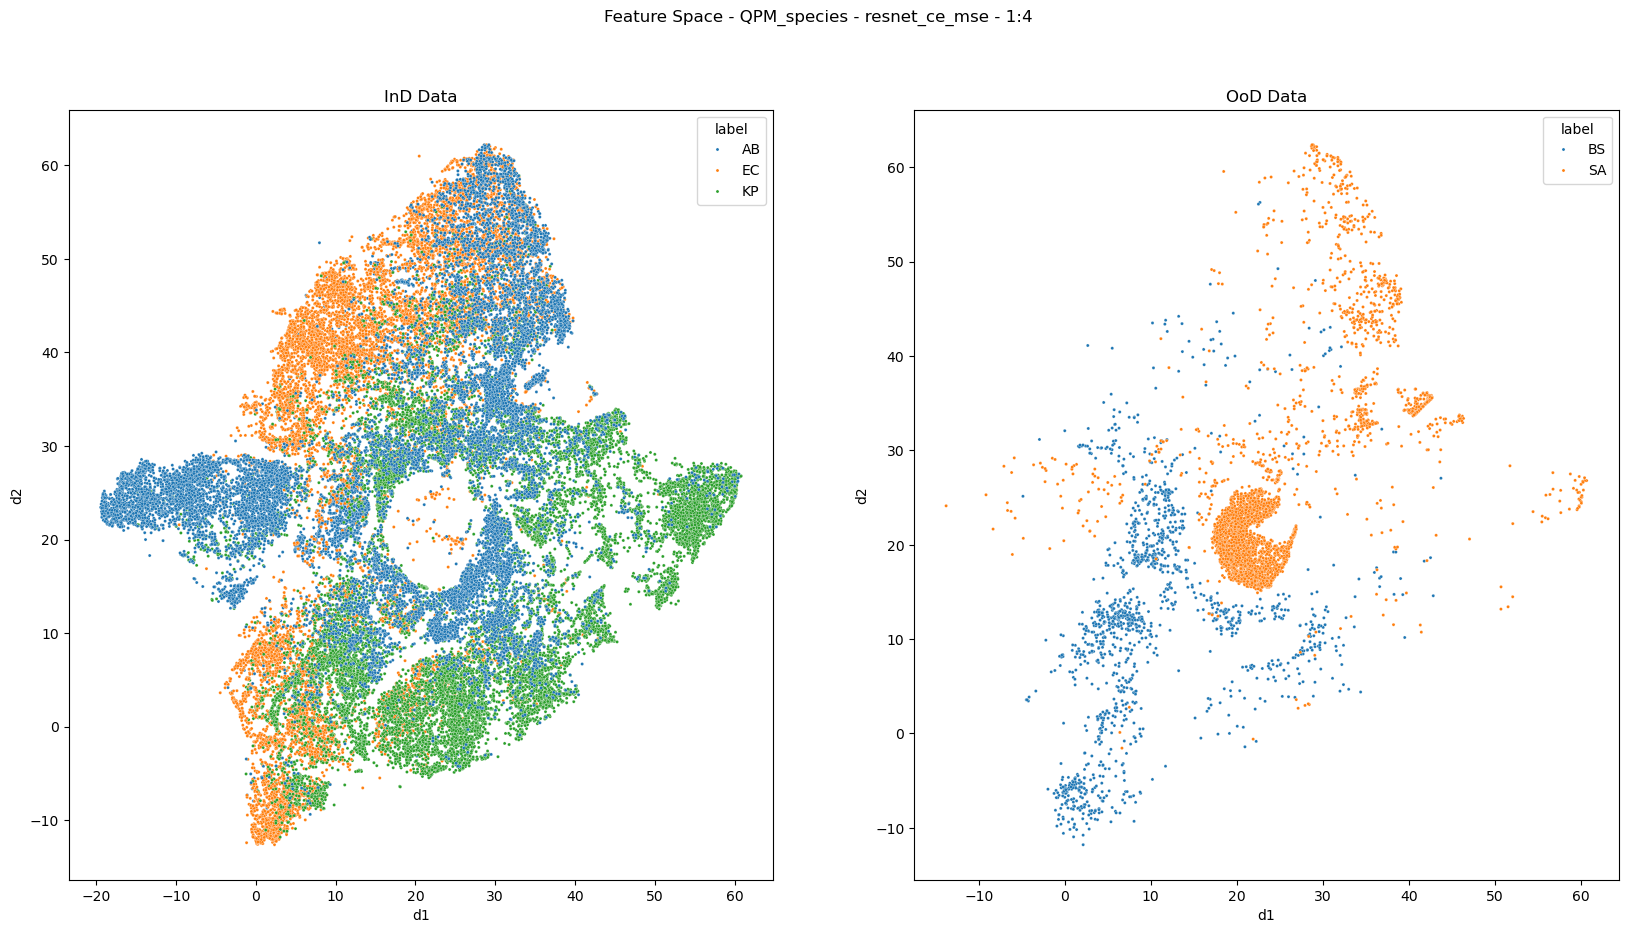

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

ftr_data = pd.DataFrame()
d1, d2 = ind_ftr2d.T
ftr_data = pd.concat([ftr_data, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_ftr2d.T
    ftr_data = pd.concat([ftr_data, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=ftr_data[(ftr_data['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=ftr_data[(ftr_data['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

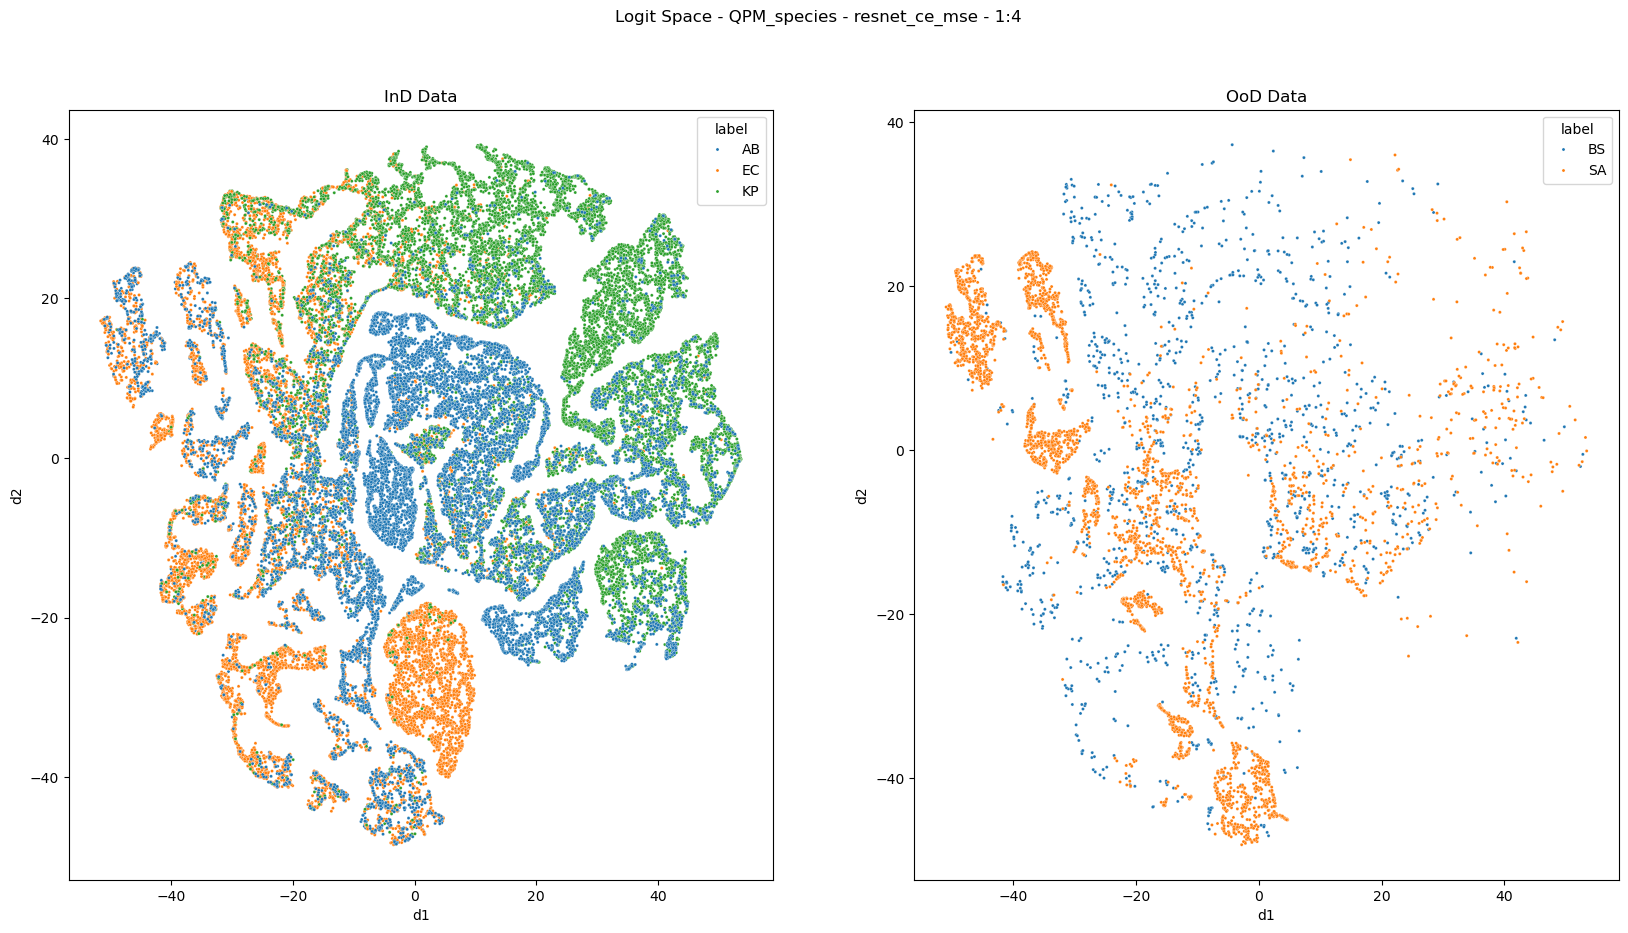

In [14]:
lgt_data = pd.DataFrame()
d1, d2 = ind_lgt2d.T
lgt_data = pd.concat([lgt_data, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    lgt_data = pd.concat([lgt_data, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=lgt_data[(lgt_data['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=lgt_data[(lgt_data['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

  0%|                                                                                                                                                               | 0/4 [00:00<?, ?it/s]

 25%|█████████████████████████████████████▊                                                                                                                 | 1/4 [00:14<00:42, 14.33s/it]

 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 2/4 [00:28<00:28, 14.31s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 3/4 [00:43<00:14, 14.37s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:57<00:00, 14.55s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:57<00:00, 14.47s/it]

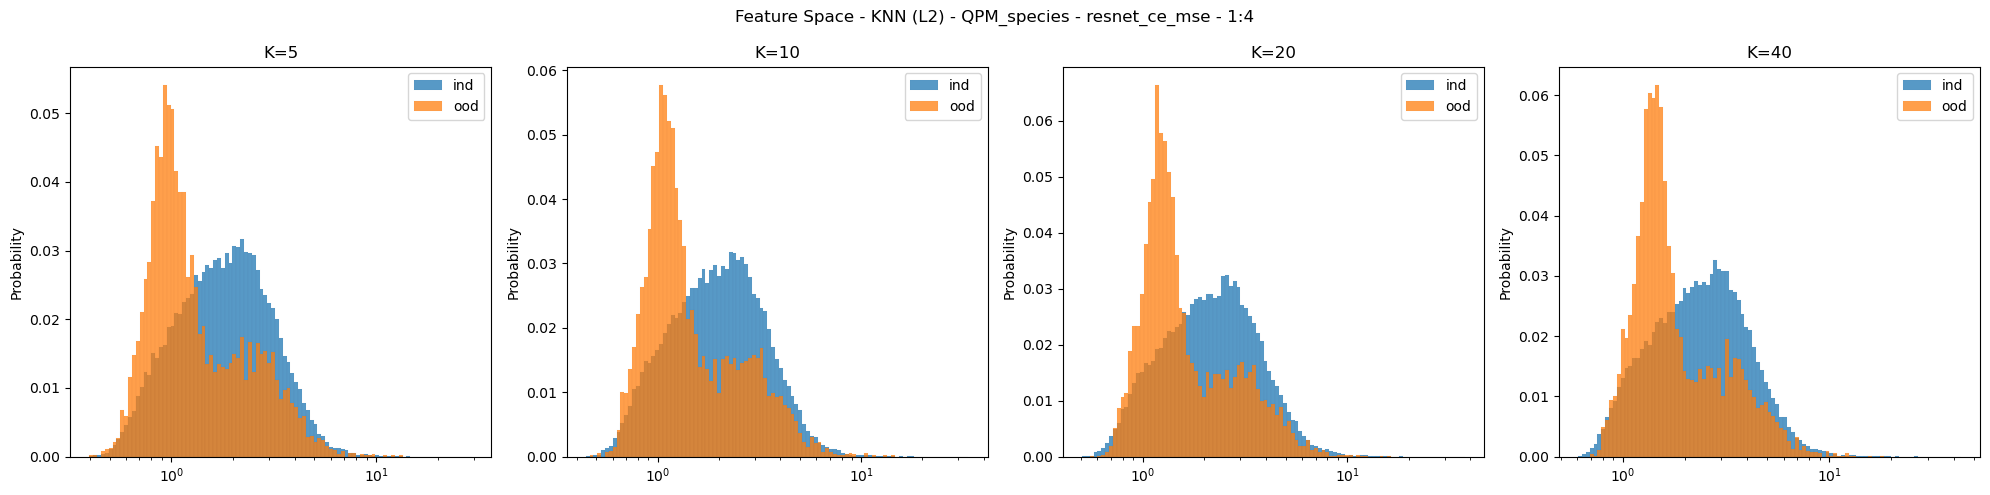

In [15]:
import faiss

index_ftr = faiss.IndexFlatL2(ind_ftr.shape[-1])
index_ftr.add(ind_ftr)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_ftr.search(ind_ftr, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_ftr.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                                               | 0/4 [00:00<?, ?it/s]

 25%|█████████████████████████████████████▊                                                                                                                 | 1/4 [00:13<00:39, 13.01s/it]

 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 2/4 [00:26<00:26, 13.19s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 3/4 [00:39<00:13, 13.21s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:53<00:00, 13.33s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:53<00:00, 13.27s/it]

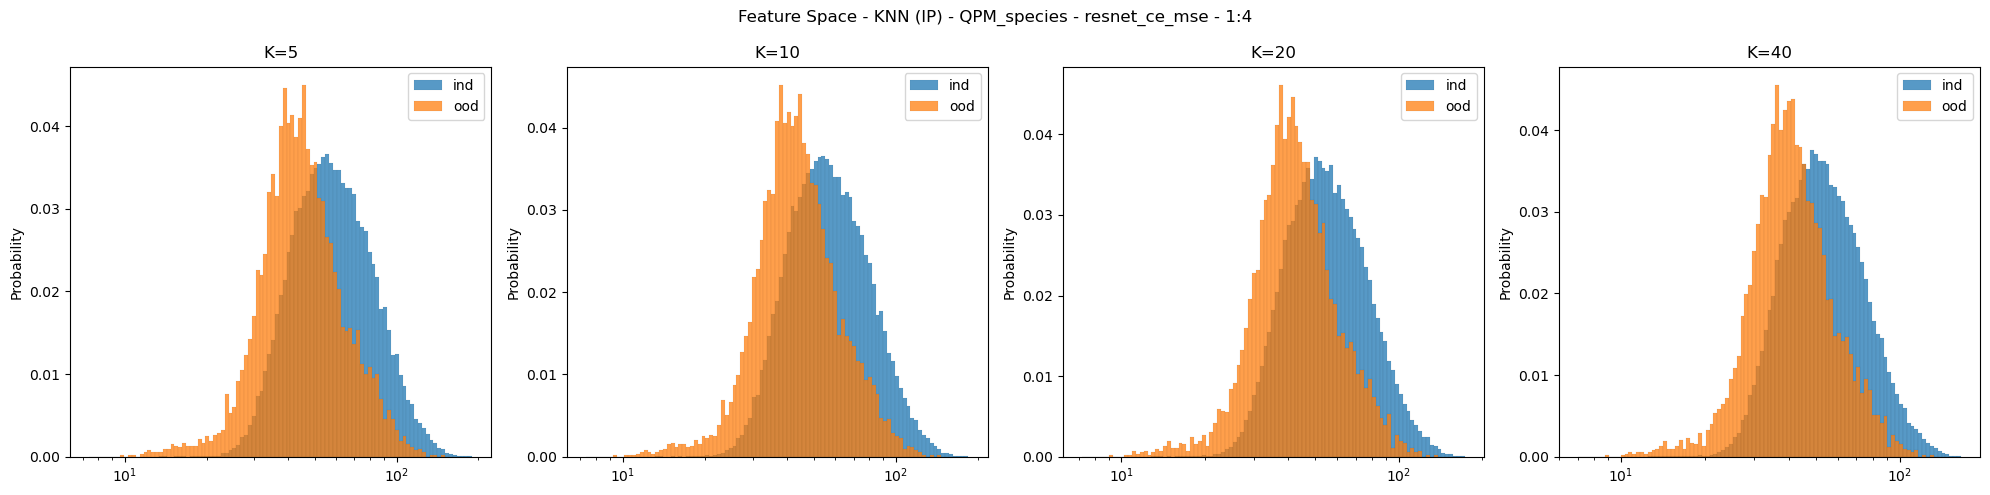

In [16]:
import faiss

index_ftr = faiss.IndexFlatIP(ind_ftr.shape[-1])
index_ftr.add(ind_ftr)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_ftr.search(ind_ftr, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_ftr.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                                               | 0/4 [00:00<?, ?it/s]

 25%|█████████████████████████████████████▊                                                                                                                 | 1/4 [00:12<00:38, 12.98s/it]

 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 2/4 [00:26<00:26, 13.04s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 3/4 [00:39<00:13, 13.10s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:53<00:00, 13.38s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:53<00:00, 13.26s/it]

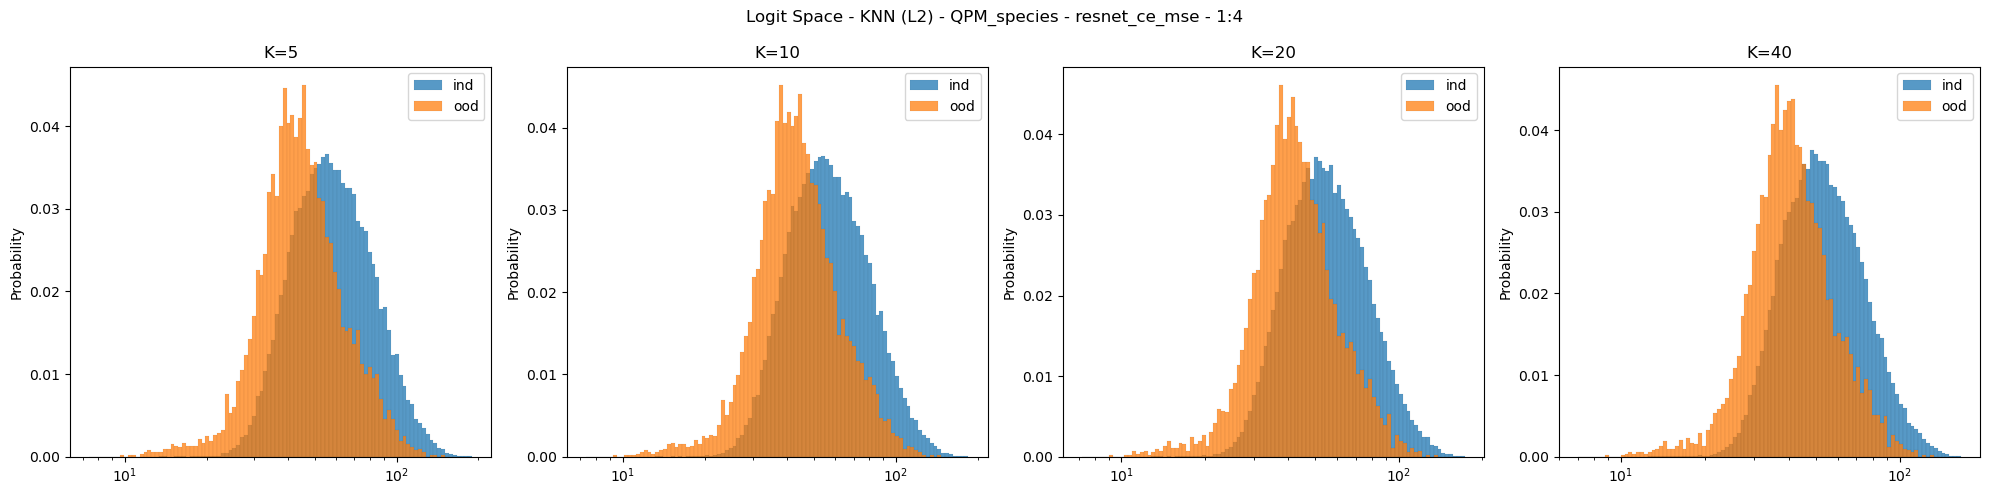

In [17]:
import faiss

index_lgt = faiss.IndexFlatL2(ind_lgt.shape[-1])
index_lgt.add(ind_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_ftr.search(ind_ftr, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_ftr.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                                               | 0/4 [00:00<?, ?it/s]

 25%|█████████████████████████████████████▊                                                                                                                 | 1/4 [00:13<00:39, 13.17s/it]

 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 2/4 [00:26<00:26, 13.37s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 3/4 [00:40<00:13, 13.66s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:55<00:00, 14.15s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:55<00:00, 13.89s/it]

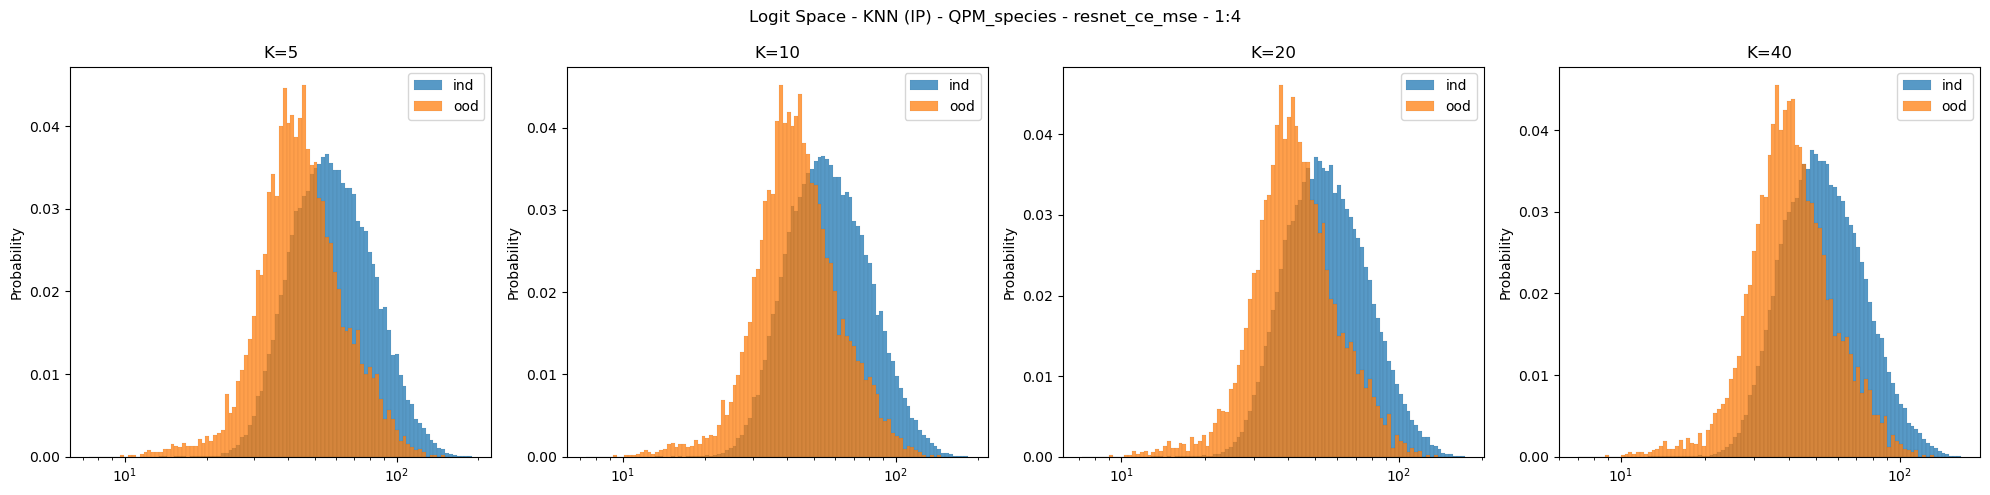

In [18]:
import faiss

index_lgt = faiss.IndexFlatIP(ind_lgt.shape[-1])
index_lgt.add(ind_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_ftr.search(ind_ftr, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_ftr.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

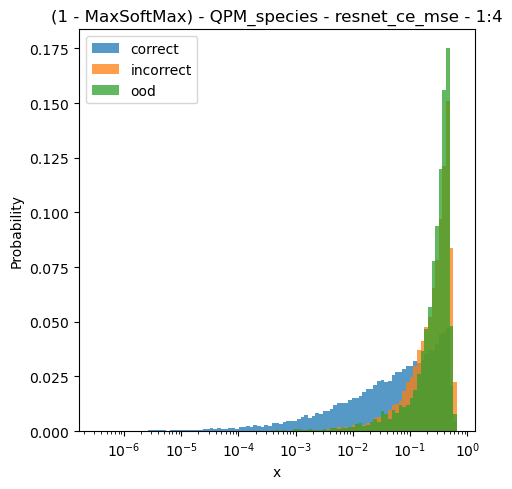

In [19]:
ind_prob = np.exp(ind_lgt) / np.exp(ind_lgt).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt) / np.exp(ood_lgt).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.logspace(np.log10(df['x'].min() + 1e-7), np.log10(df['x'].max()), 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
ax.set_xscale("log")
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()